# SETUP

In [1]:
USE_GPU = True

In [2]:
!pip install --upgrade pip tensorflow keras jupyterlab-vim maap-user-workspace-management-jupyter-extension pydot
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  gyp javascript-common libauthen-sasl-perl libc-ares2 libclone-perl
  libdata-dump-perl libencode-locale-perl libfile-basedir-perl
  libfile-desktopentry-perl libfile-listing-perl libfile-mimeinfo-perl
  libfont-afm-perl libfontenc1 libgtkd-3-0 libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libio-html-perl
  libio-socket-ssl-perl libio-stringy-perl libipc-system-simple-perl
  libjs-events libjs-highlight.js libjs-inherits libjs-is-typedarray libjs-psl
  libjs-source-map libjs-sprintf-js libjs-typedarray-to-buffer libllvm11
  liblwp-mediatypes-perl liblwp-protocol-https-perl libmailtools-perl
  libnet-dbus-perl libnet-http-perl libnet-smtp-ssl-perl libnet-s

In [3]:
!jupyter labextension list

JupyterLab v4.4.5
/usr/local/share/jupyter/labextensions
        jupyterlab_pygments v0.2.2 enabled  X (python, jupyterlab_pygments)
        jupyter-matplotlib v0.11.7 enabled OK
        maap-user-workspace-management-jupyter-extension v0.1.5 enabled OK (python, maap_user_workspace_management_jupyter_extension)
        jupyterlab-indent-guides v0.1.0 enabled OK (python, jupyterlab-indent-guides)
        @jupyter-widgets/jupyterlab-manager v5.0.9 enabled OK (python, jupyterlab_widgets)
        @jupyter-notebook/lab-extension v7.0.5 enabled OK
        @axlair/jupyterlab_vim v4.1.4 enabled OK (python, jupyterlab_vim)


   The following extensions may be outdated or specify dependencies that are incompatible with the current version of jupyterlab:
        jupyterlab_pygments
        
   If you are a user, check if an update is available for these packages.
   If you are a developer, re-run with `--verbose` flag for more details.

Other labextensions (built into JupyterLab)
   app dir: /usr

## Libraries

In [4]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging

# Data
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
from keras.models import load_model
import keras.backend as K

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.time_series_utils import splitTrainTestTimeSeries, reframePastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# My custom libraries
from src.plot import plot_1_data, plot_2_data
from src.data_util import mice

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1754386352.492937 1644023 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754386352.499599 1644023 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754386352.516405 1644023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754386352.516436 1644023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754386352.516438 1644023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754386352.516439 1644023 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


W0000 00:00:1754386355.125921 1644023 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Configuration

In [5]:
confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data
print(conf)

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx",
            "target_start_date": "2022-01-01",
            "target_end_date": "2022-12-31"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.c

# MPAIR DATA ALL LOCATIONS

## Load dataset

* Every row has a tuple (i, j) which marks a "cell" in the Ho Chi Minh City grid map

| i/j | 0 | 1 | 2 | ... |
|-----|---|---|---|-----|
| 0   |   |   |   |     |
| 1   |   |   |   |     |
| 2   |   |   |   |     |
| ... |   |   |   |     |

* Every cell has its own geographical characteristics
* Every cell represent values of a specific date and specific location

### Raw data

In [6]:
df_mpair_raw = pd.read_csv(conf["dataset"]["mpair"]["merged_data_dir_all_locations"], index_col=None)
df_mpair_raw

,i,j,lat,lon,time,pm25_3km,tmp,rh,hpbl,wspd,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
0,0,3,11.149747,106.369103,2021-01-01,26.040001,25.114687,63.633778,567.478943,4.660580,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
1,0,3,11.149747,106.369103,2021-01-02,39.470001,24.043423,69.082085,485.584290,3.288929,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2,0,3,11.149747,106.369103,2021-01-03,40.619999,25.058735,67.647362,403.936310,2.731468,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
3,0,3,11.149747,106.369103,2021-01-04,40.330002,25.554197,71.023094,704.476807,3.522596,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.555355,NaN,NaN
4,0,3,11.149747,106.369103,2021-01-05,50.009998,25.037054,74.029236,534.426575,3.223711,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713205,34,27,10.385233,106.918383,2022-12-27,19.874584,24.644707,76.055573,441.420624,2.561953,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
713206,34,27,10.385233,106.918383,2022-12-28,17.509365,25.071791,78.165489,403.261658,2.126233,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
713207,34,27,10.385233,106.918383,2022-12-29,18.428423,25.458431,79.421234,425.696411,1.909332,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,0.174487,NaN,NaN
713208,34,27,10.385233,106.918383,2022-12-30,12.645213,24.636055,76.198395,241.369736,2.530340,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN


In [7]:
df_mpair_raw.columns

Index(['i', 'j', 'lat', 'lon', 'time', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd',
       'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland',
       'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi', 'aod',
       'station', 'pm25'],
      dtype='object')

In [8]:
df_mpair_raw.isnull().sum()

i                         0
j                         0
lat                       0
lon                       0
time                      0
pm25_3km                  0
tmp                       0
rh                        0
hpbl                      0
wspd                      0
pop                       0
road_den_1km              0
prim_road_len_1km    708830
near_dist                 0
bareland                  0
builtup                   0
cropland                  0
grassland                 0
treecover                 0
water                     0
ndvi                 556260
aod                  429477
station              709195
pm25                 710637
dtype: int64

### Handle metadata

In [9]:
# Convert "time" columns to Pandas datetime
df_mpair_raw = df_mpair_raw.assign(time=pd.to_datetime(df_mpair_raw["time"]))

# Set "time" column as index
df_mpair_raw.set_index("time", inplace=True)

# Convert the -9999 to nan
df_mpair_raw[df_mpair_raw <= -9999] = np.nan

# Print
df_mpair_raw

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0,3,11.149747,106.369103,26.040001,25.114687,63.633778,567.478943,4.660580,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2021-01-02,0,3,11.149747,106.369103,39.470001,24.043423,69.082085,485.584290,3.288929,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2021-01-03,0,3,11.149747,106.369103,40.619999,25.058735,67.647362,403.936310,2.731468,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
2021-01-04,0,3,11.149747,106.369103,40.330002,25.554197,71.023094,704.476807,3.522596,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.555355,NaN,NaN
2021-01-05,0,3,11.149747,106.369103,50.009998,25.037054,74.029236,534.426575,3.223711,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-12-28,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-12-29,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,0.174487,NaN,NaN


## Preprocessing

In [10]:
df_mpair = copy.deepcopy(df_mpair_raw)

### Sort data by locations with stations, then locations without stations

#### Define locations with stations

In [11]:
locations_with_stations = sorted(list(df_mpair.loc[:, ["i", "j", "station"]].drop_duplicates().dropna().drop(columns=["station"]).itertuples(name=None, index=None)))
print(f"locations_with_stations = {locations_with_stations}")

all_locations = sorted(list(df_mpair.loc[:, ["i", "j"]].drop_duplicates().itertuples(name=None, index=None)))
print(f"\nall_locations = {all_locations}")

locations_without_stations = sorted(list(set(all_locations) - set(locations_with_stations)))
print()
print(f"\nlocations_without_stations = {locations_without_stations}")

sorted_locations = locations_with_stations + locations_without_stations
print(f"\nsorted_locations = {sorted_locations}")

locations_with_stations = [(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]

all_locations = [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 

#### Sort data by stations

In [12]:
all_sorted_dfs = []
for (i, j) in sorted_locations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    # Fill station data
    df_mpair_current_ij.loc[:, "station"] = df_mpair_current_ij["station"].iloc[0]
    # Append data
    all_sorted_dfs.append(df_mpair_current_ij)

df_mpair = pd.concat(all_sorted_dfs)
df_mpair

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,12,22,10.879919,106.803950,30.366625,25.749989,61.403439,533.919250,3.311250,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
2021-01-02,12,22,10.879919,106.803950,46.732498,25.407879,59.282650,568.372009,2.977586,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,0.247559,211.0,NaN
2021-01-03,12,22,10.879919,106.803950,45.280472,26.828142,61.058357,500.588928,1.905266,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
2021-01-04,12,22,10.879919,106.803950,49.504631,27.283474,62.222889,603.052551,2.034556,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
2021-01-05,12,22,10.879919,106.803950,60.881470,27.231569,63.081909,524.814148,2.716187,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-12-28,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-12-29,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,0.174487,NaN,NaN


### Statistic

In [13]:
null_df = []
for (i, j) in locations_with_stations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    null_df.append(df_mpair_current_ij.isnull().sum())
null_df = pd.concat(null_df, axis=1).set_axis([f"{i},{j}" for (i, j) in locations_with_stations], axis=1)
null_df

,"12,22","15,14","15,18","16,16","16,17","17,17","18,14"
i,0,0,0,0,0,0,0
j,0,0,0,0,0,0,0
lat,0,0,0,0,0,0,0
lon,0,0,0,0,0,0,0
pm25_3km,0,0,0,0,0,0,0
tmp,0,0,0,0,0,0,0
rh,0,0,0,0,0,0,0
hpbl,0,0,0,0,0,0,0
wspd,0,0,0,0,0,0,0
pop,0,0,0,0,0,0,0


### Handle missing values

#### Check missing values for each location

In [14]:
# Check missing values for every location which have station
null_df = []
for (i, j) in locations_with_stations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    null_df.append(df_mpair_current_ij.isnull().sum())
null_df = pd.concat(null_df, axis=1).set_axis([f"{i},{j}" for (i, j) in locations_with_stations], axis=1)
display(null_df)

# Check missing values for every location which doesn't have station
null_df = []
for (i, j) in locations_without_stations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    null_df.append(df_mpair_current_ij.isnull().sum())
null_df = pd.concat(null_df, axis=1).set_axis([f"{i},{j}" for (i, j) in locations_without_stations], axis=1)
display(null_df)

,"12,22","15,14","15,18","16,16","16,17","17,17","18,14"
i,0,0,0,0,0,0,0
j,0,0,0,0,0,0,0
lat,0,0,0,0,0,0,0
lon,0,0,0,0,0,0,0
pm25_3km,0,0,0,0,0,0,0
tmp,0,0,0,0,0,0,0
rh,0,0,0,0,0,0,0
hpbl,0,0,0,0,0,0,0
wspd,0,0,0,0,0,0,0
pop,0,0,0,0,0,0,0


,"0,3","0,4","0,5","0,6","0,7","0,8","0,9","0,10","0,11","0,12",...,"34,14","34,15","34,16","34,17","34,18","34,19","34,20","34,21","34,26","34,27"
i,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
j,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pm25_3km,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tmp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hpbl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wspd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Drop columns

In [15]:
#columns_to_drop = ["prim_road_len_1km", "ndvi", "aod"]
columns_to_drop = []
df_mpair.drop(columns=columns_to_drop, inplace=True)
df_mpair

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,12,22,10.879919,106.803950,30.366625,25.749989,61.403439,533.919250,3.311250,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
2021-01-02,12,22,10.879919,106.803950,46.732498,25.407879,59.282650,568.372009,2.977586,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,0.247559,211.0,NaN
2021-01-03,12,22,10.879919,106.803950,45.280472,26.828142,61.058357,500.588928,1.905266,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
2021-01-04,12,22,10.879919,106.803950,49.504631,27.283474,62.222889,603.052551,2.034556,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
2021-01-05,12,22,10.879919,106.803950,60.881470,27.231569,63.081909,524.814148,2.716187,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,NaN,NaN,211.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-12-28,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,NaN,NaN,NaN
2022-12-29,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,NaN,0.174487,NaN,NaN


#### Define label, static features and dynamic features

In [16]:
print(df_mpair.columns)
mpair_label = ["pm25"]
mpair_stat_feats = ['lat', 'lon', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
mpair_stat_feats = list(set(mpair_stat_feats) - set(columns_to_drop))

mpair_dyn_feats = list(set(df_mpair.columns) - set(mpair_stat_feats) - set(mpair_label) - set(["i", "j", "station", "pm25_3km"]))
mpair_dyn_feats = list(set(mpair_dyn_feats) - set(columns_to_drop))

print(f"mpair_label = {mpair_label}\n\
mpair_stat_feats = {mpair_stat_feats}\n\
mpair_dyn_feats = {mpair_dyn_feats}\n")

Index(['i', 'j', 'lat', 'lon', 'pm25_3km', 'tmp', 'rh', 'hpbl', 'wspd', 'pop',
       'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup',
       'cropland', 'grassland', 'treecover', 'water', 'ndvi', 'aod', 'station',
       'pm25'],
      dtype='object')
mpair_label = ['pm25']
mpair_stat_feats = ['treecover', 'water', 'builtup', 'near_dist', 'grassland', 'ndvi', 'lat', 'pop', 'cropland', 'road_den_1km', 'bareland', 'lon', 'prim_road_len_1km']
mpair_dyn_feats = ['wspd', 'tmp', 'rh', 'aod', 'hpbl']



In [17]:
null_stat = df_mpair.isnull().sum()
display(null_stat)
columns_to_fill = list(null_stat[null_stat > 0].keys())
stat_feats_to_fill = set(columns_to_fill) & set(mpair_stat_feats)
dyn_feats_to_fill = set(columns_to_fill) & set(mpair_dyn_feats)
print(f"columns_to_fill = {columns_to_fill}\n\
stat_feats_to_fill = {stat_feats_to_fill}\n\
dyn_feats_to_fill = {dyn_feats_to_fill}\n")

i                         0
j                         0
lat                       0
lon                       0
pm25_3km                  0
tmp                       0
rh                        0
hpbl                      0
wspd                      0
pop                       0
road_den_1km              0
prim_road_len_1km    708830
near_dist                 0
bareland                  0
builtup                   0
cropland                  0
grassland                 0
treecover                 0
water                     0
ndvi                 556260
aod                  430454
station              708100
pm25                 710637
dtype: int64

columns_to_fill = ['prim_road_len_1km', 'ndvi', 'aod', 'station', 'pm25']
stat_feats_to_fill = {'ndvi', 'prim_road_len_1km'}
dyn_feats_to_fill = {'aod'}



#### Fill static features

In [18]:
if len(stat_feats_to_fill) != 0:
    all_filled_dfs = []
    for (i, j) in sorted_locations:
        df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    
        for feat in stat_feats_to_fill:
            df_mpair_current_ij.loc[:, feat] = df_mpair_current_ij[feat].fillna(value=0)
        for feat in dyn_feats_to_fill:
            df_mpair_current_ij.loc[:, feat] = df_mpair_current_ij[feat].replace([np.inf, -np.inf], np.nan)
            df_mpair_current_ij.loc[:, feat] = df_mpair_current_ij[feat].fillna(df_mpair_current_ij[feat].mean())
    
        all_filled_dfs.append(df_mpair_current_ij)
    
    df_mpair = pd.concat(all_filled_dfs)
    df_mpair
else:
    print("Static features do not have missing values")

#### Fill label

Filling label for 12, 22...


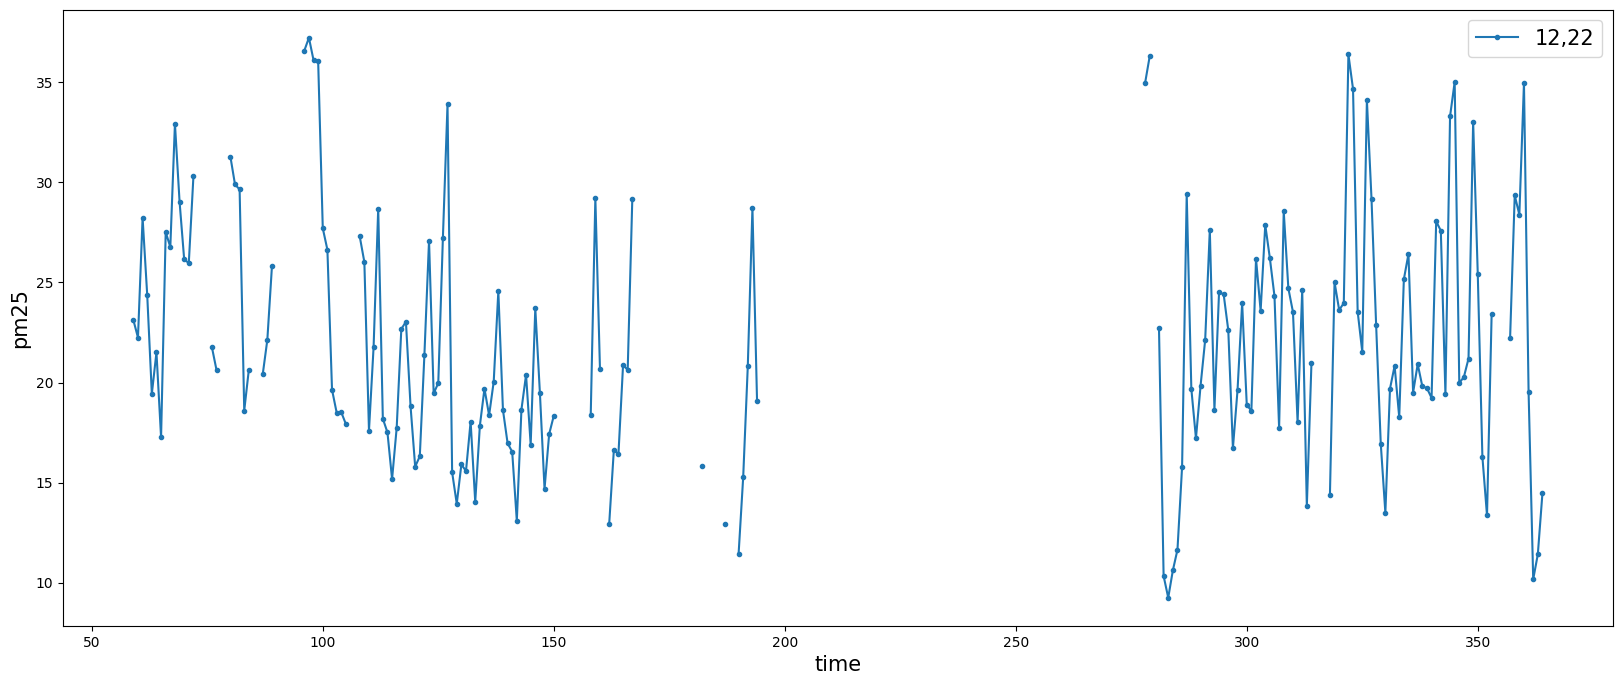

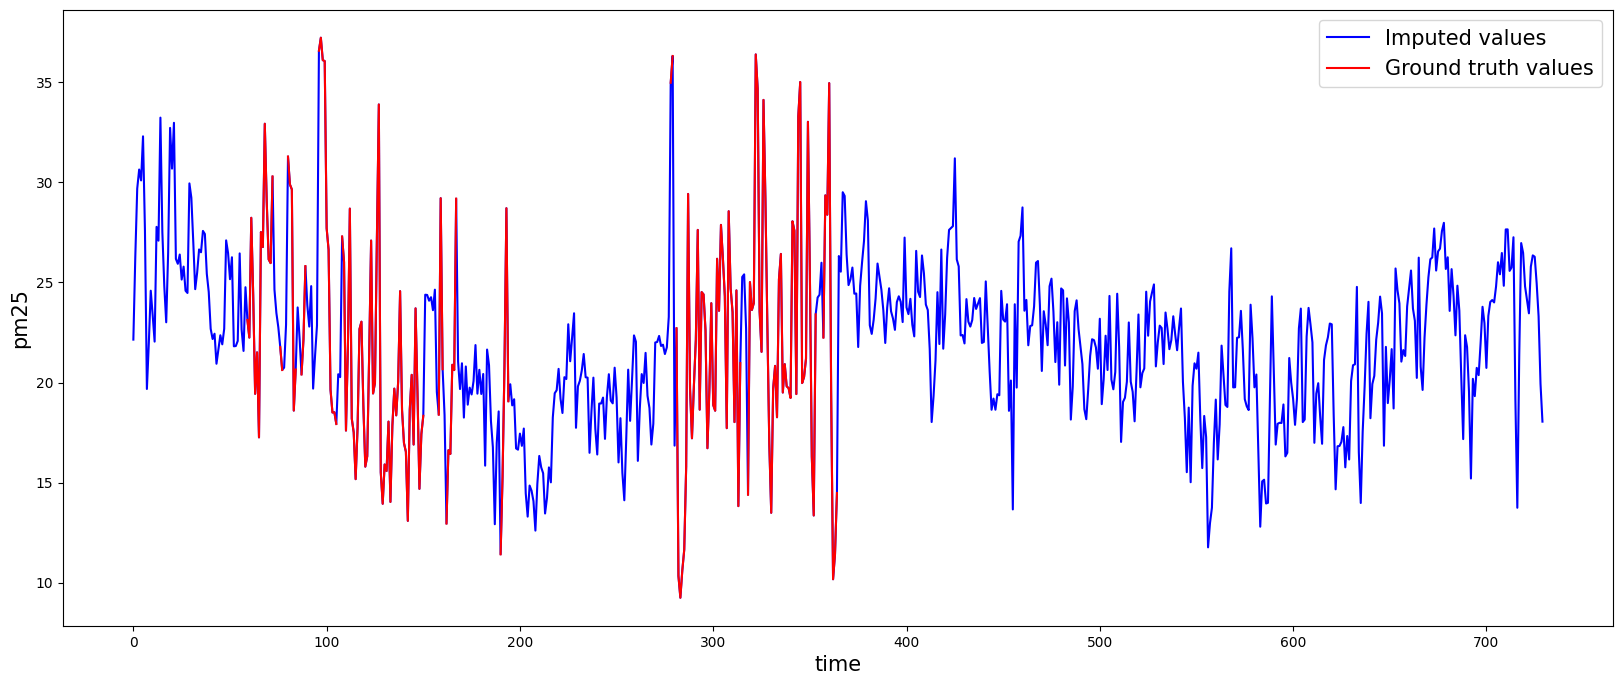

Filling label for 15, 14...


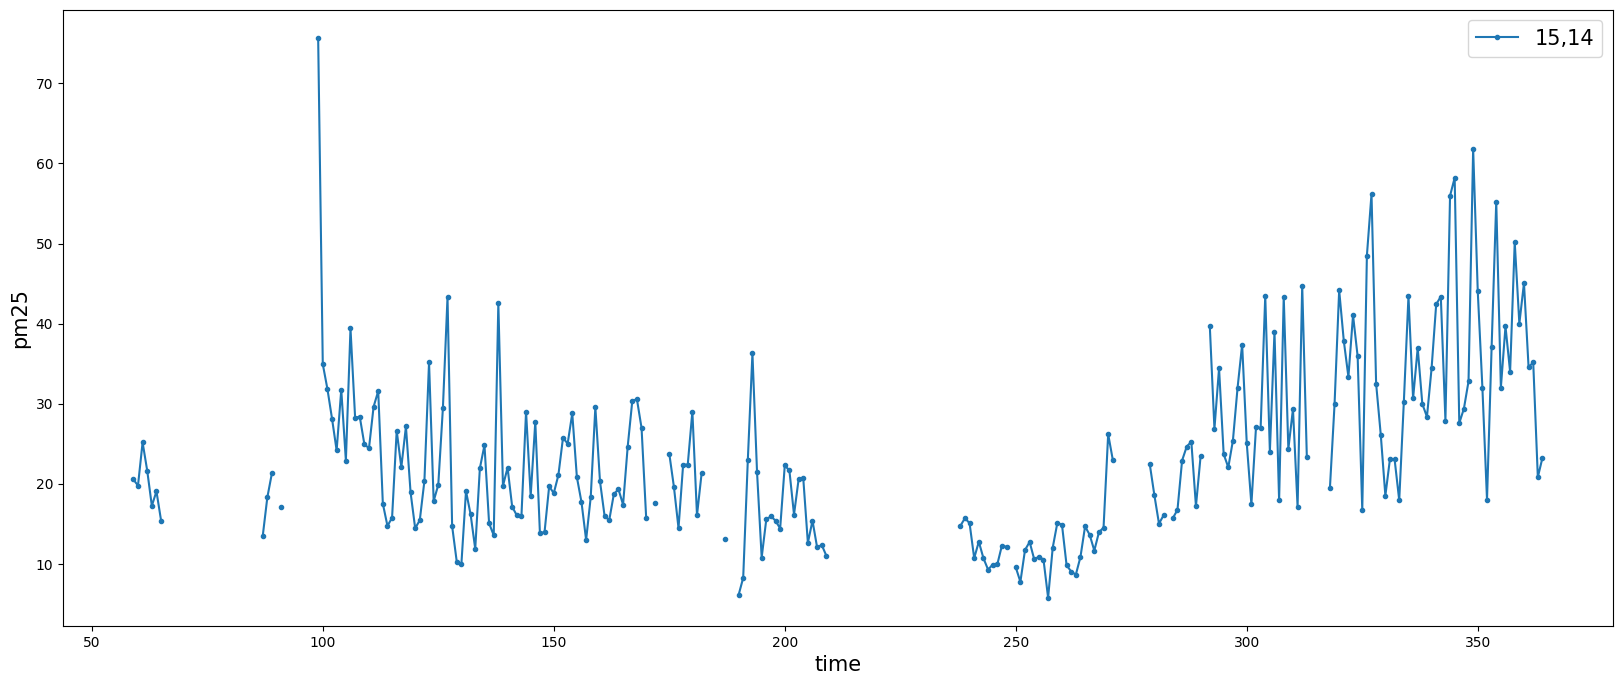

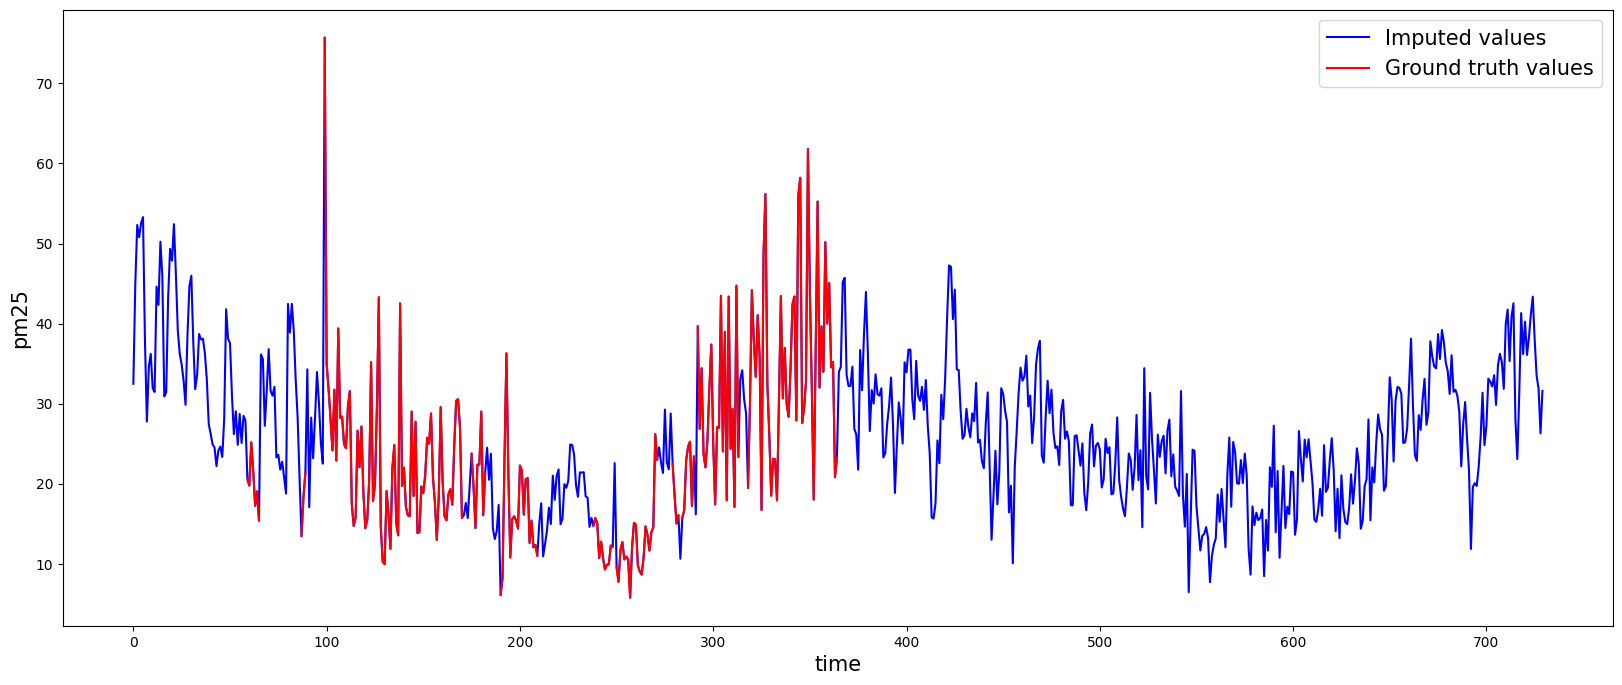

Filling label for 15, 18...


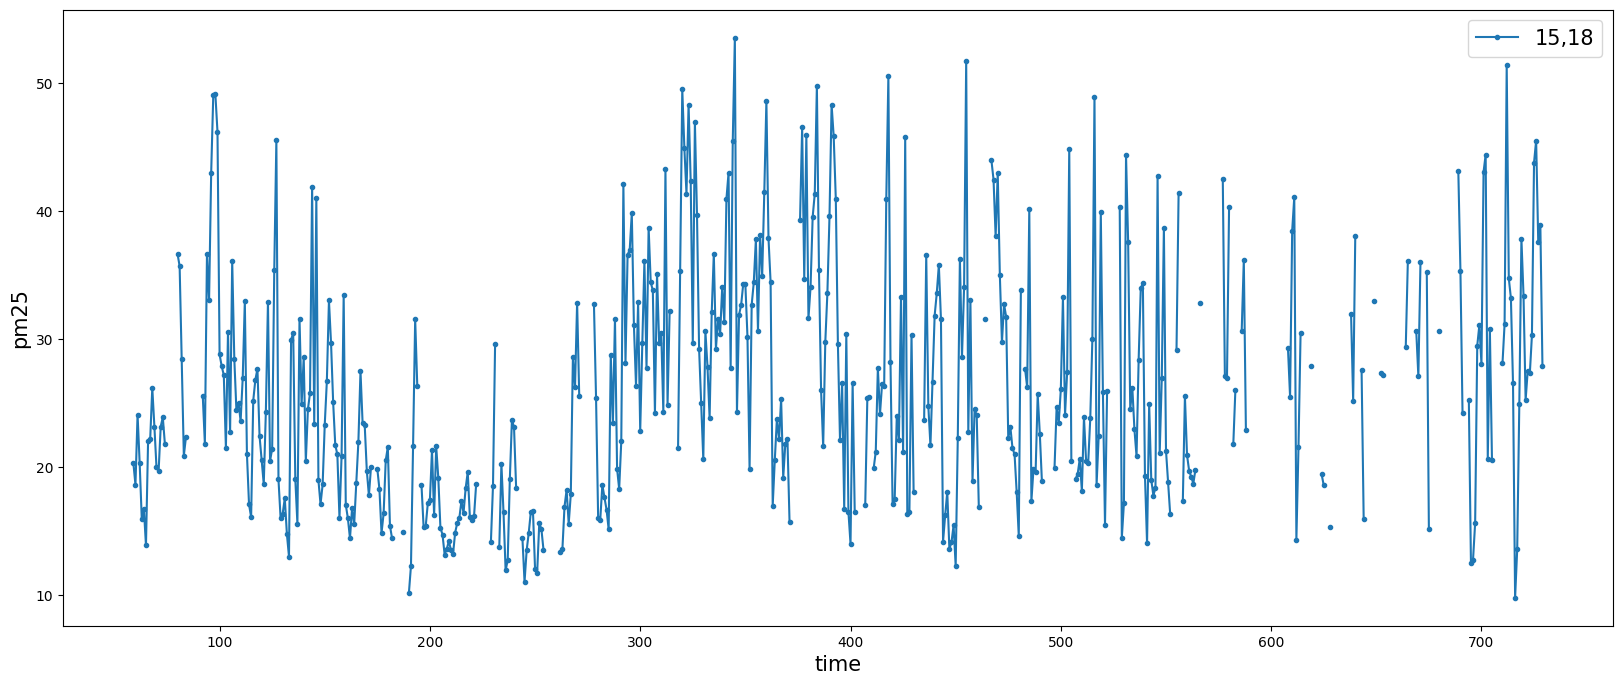

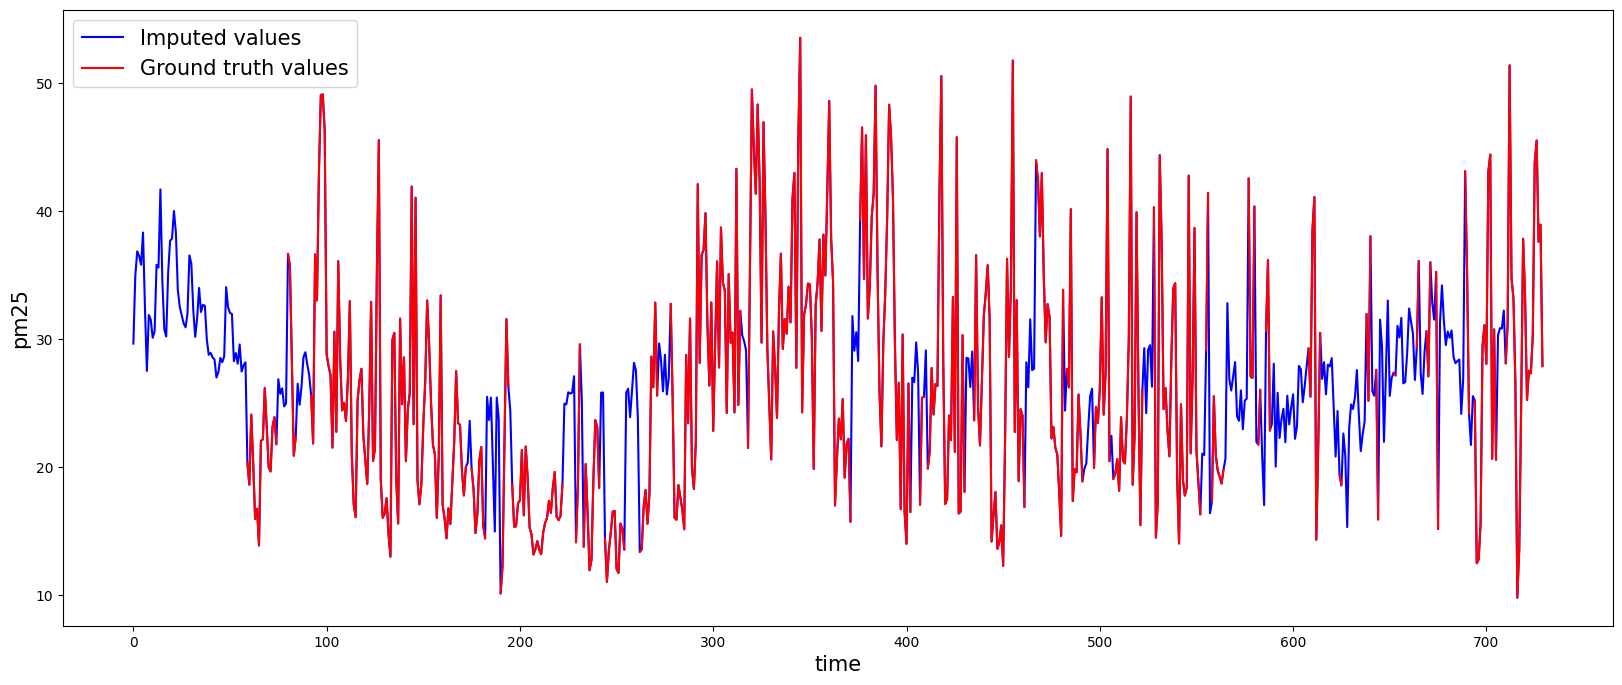

Filling label for 16, 16...


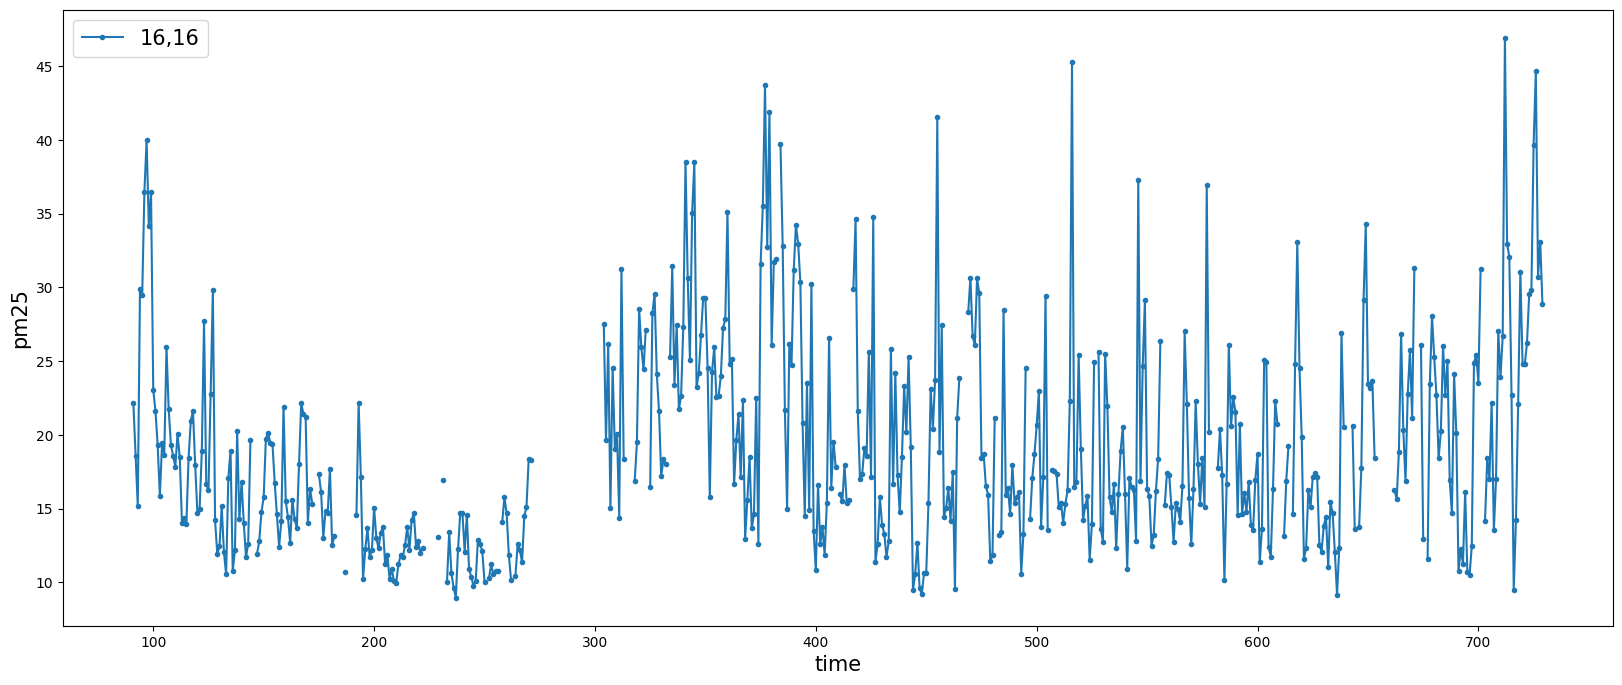

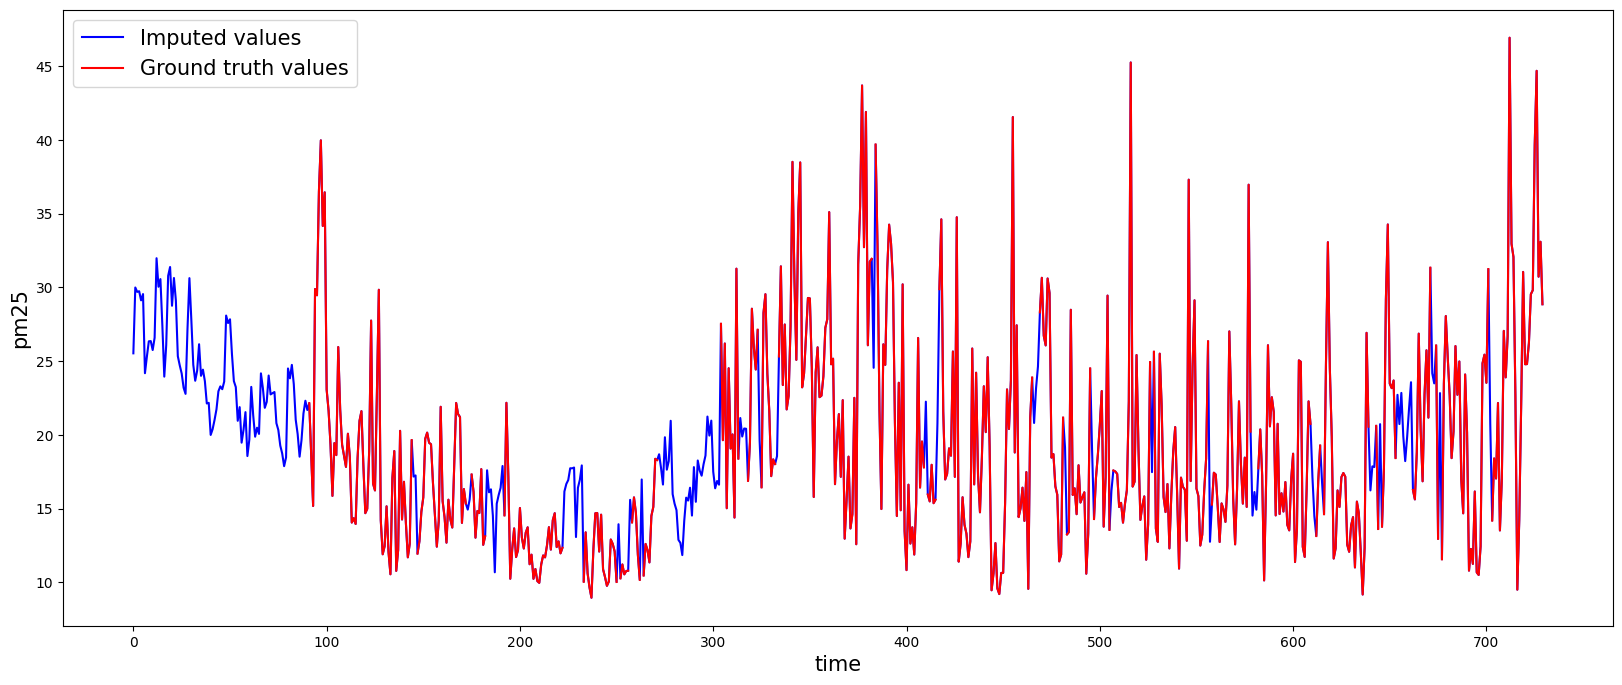

Filling label for 16, 17...


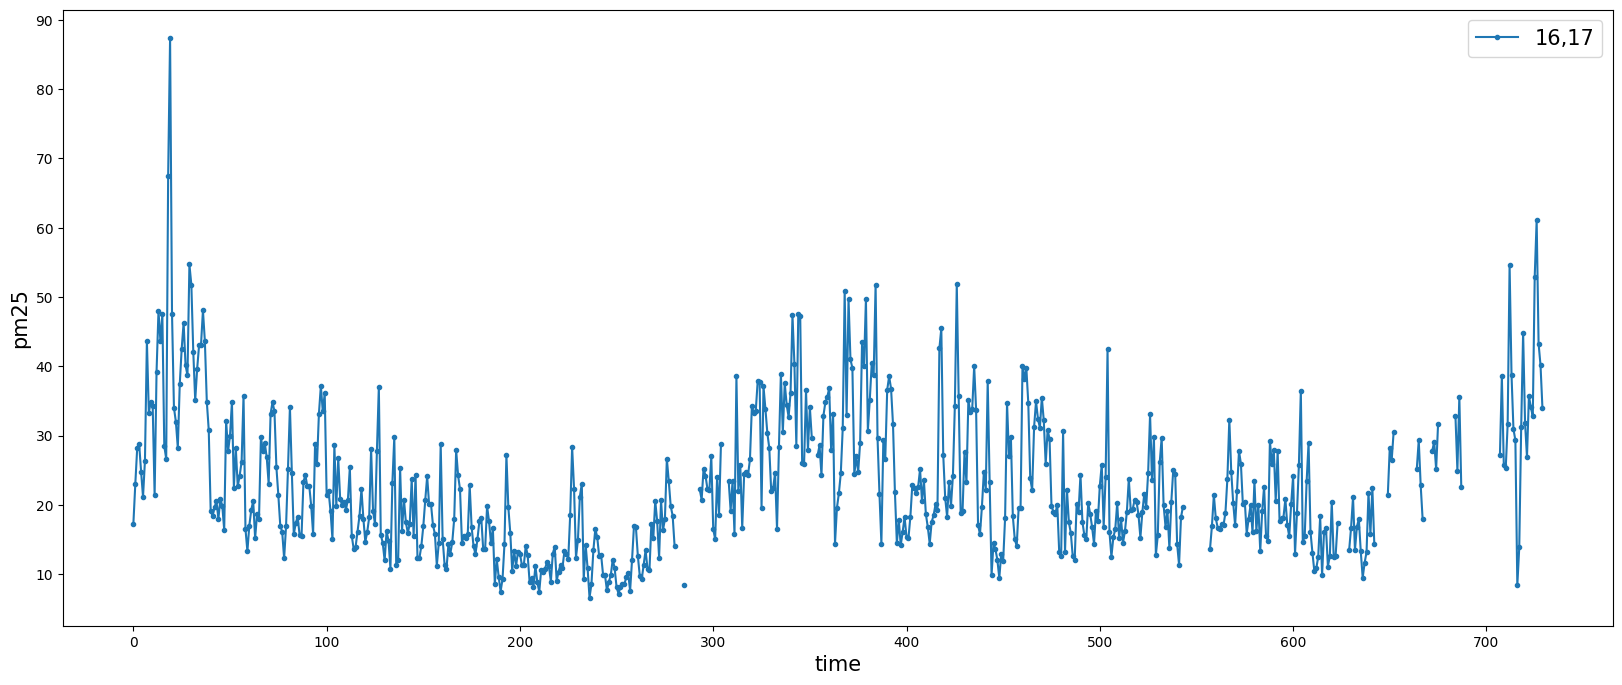

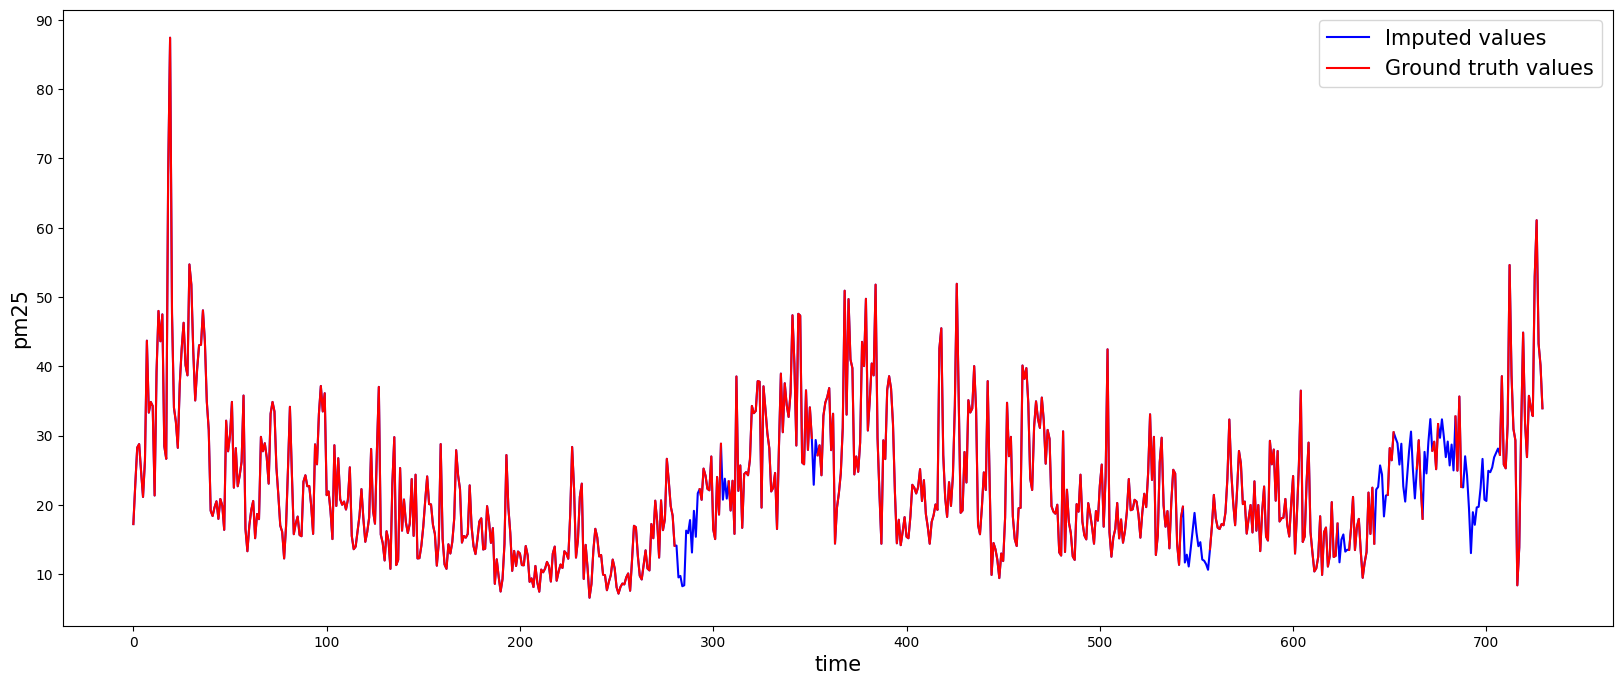

Filling label for 17, 17...


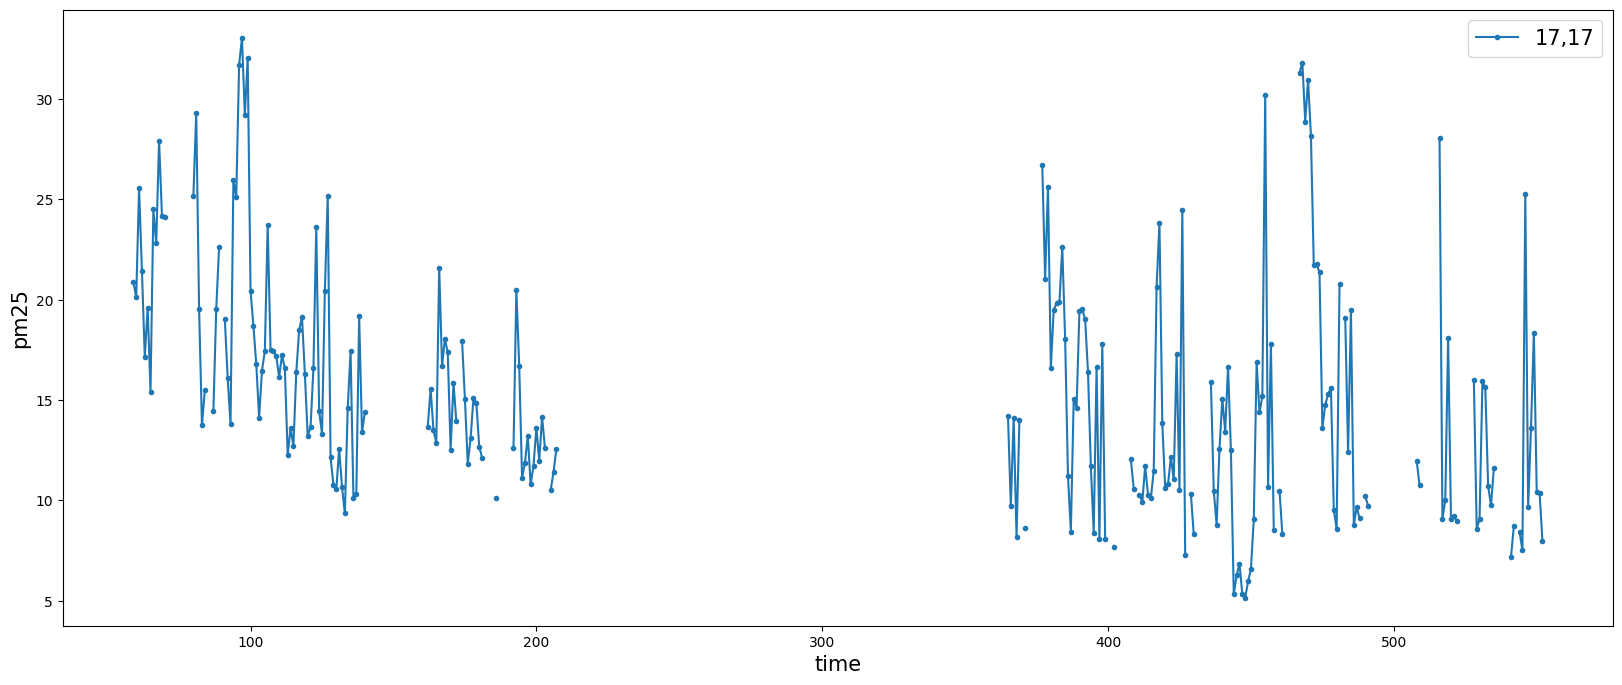

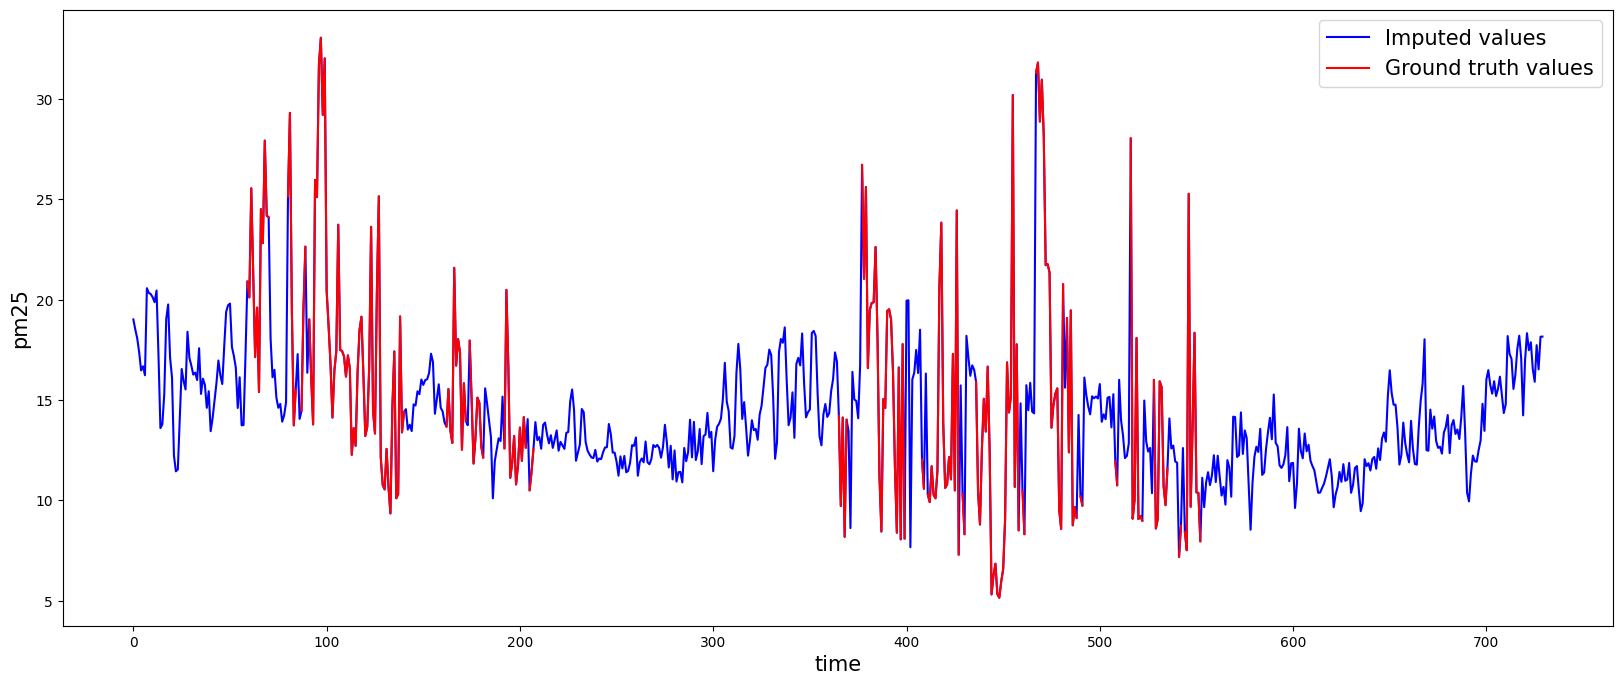

Filling label for 18, 14...


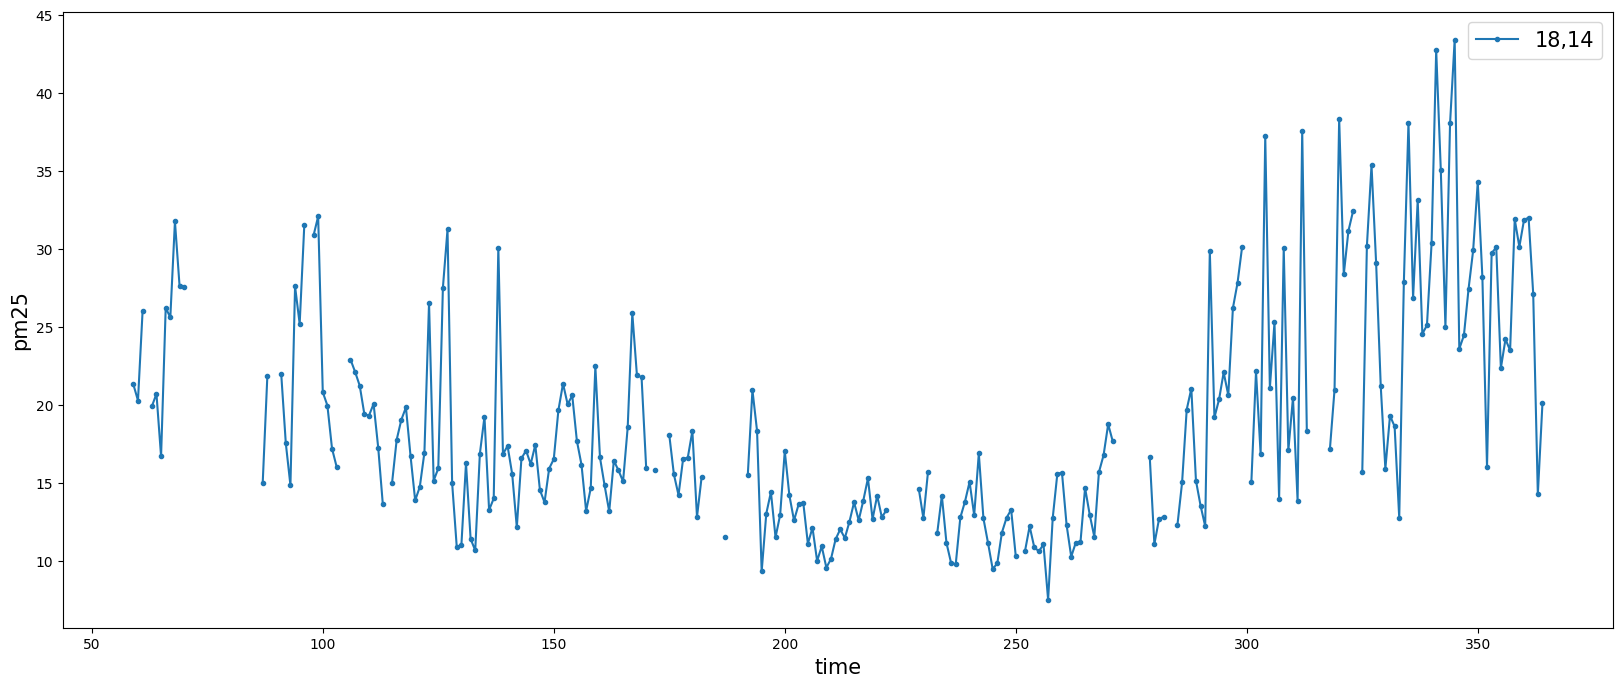

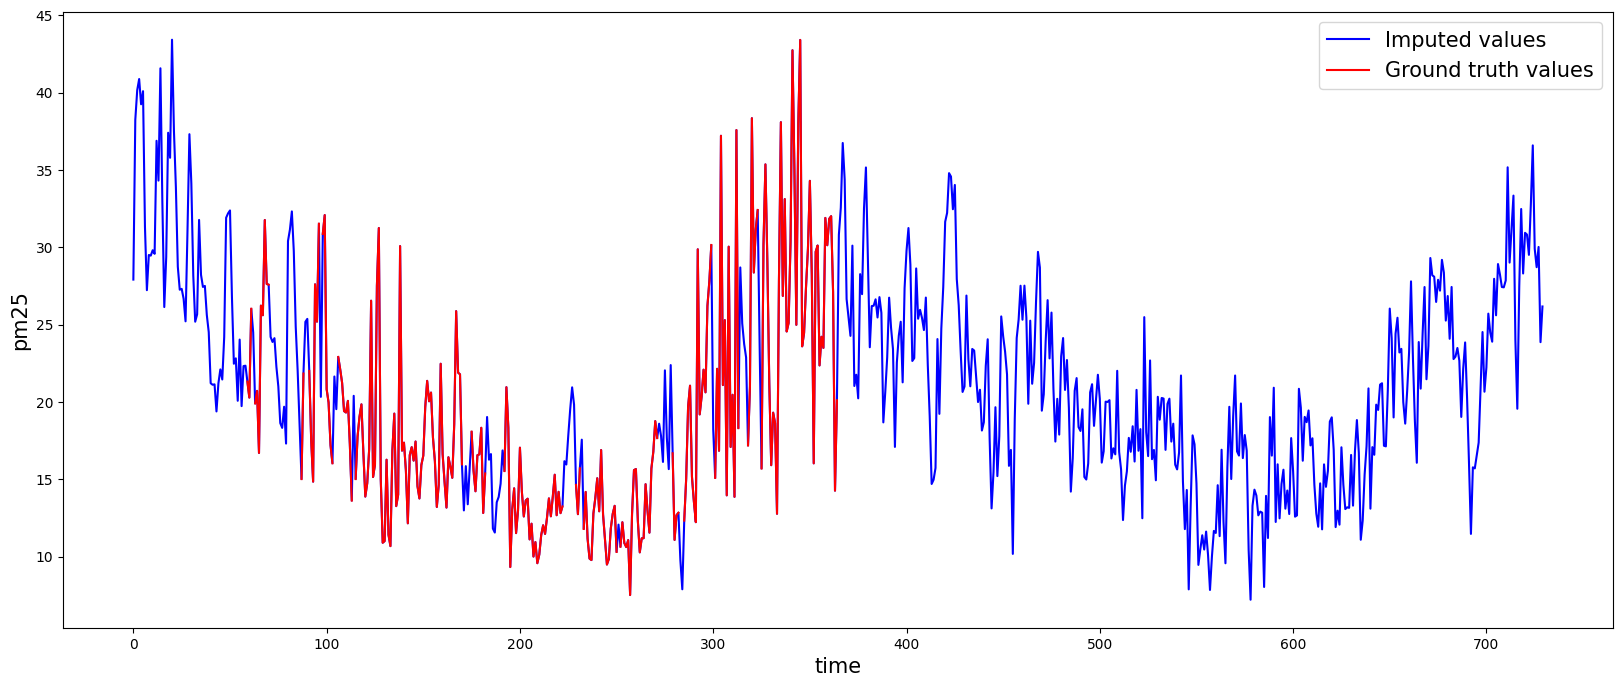

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,12,22,10.879919,106.803950,30.366625,25.749989,61.403439,533.919250,3.311250,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,22.143751
2021-01-02,12,22,10.879919,106.803950,46.732498,25.407879,59.282650,568.372009,2.977586,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.247559,211.0,26.273677
2021-01-03,12,22,10.879919,106.803950,45.280472,26.828142,61.058357,500.588928,1.905266,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,29.692751
2021-01-04,12,22,10.879919,106.803950,49.504631,27.283474,62.222889,603.052551,2.034556,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,30.644400
2021-01-05,12,22,10.879919,106.803950,60.881470,27.231569,63.081909,524.814148,2.716187,7734.3780,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.0,0.639324,211.0,30.100605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-12-28,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-12-29,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.2214,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.174487,NaN,NaN


In [19]:
all_dfs = []
for (i, j) in sorted_locations:
    df_mpair_current_ij = df_mpair.loc[(df_mpair["i"] == i) & (df_mpair["j"] == j)]
    if (i, j) in locations_with_stations:
        print(f"Filling label for {i}, {j}...")
        # Impute data
        df_mpair_current_ij_imputed = mice(df_mpair_current_ij)
        # Visualization
        plot_1_data(data=df_mpair_current_ij["pm25"], datalabel=f"{i},{j}", xlabel="time", ylabel="pm25")
        plot_2_data(data1=df_mpair_current_ij_imputed["pm25"], datalabel1="Imputed values", data2=df_mpair_current_ij["pm25"], datalabel2="Ground truth values", xlabel="time", ylabel="pm25")
        # Append imputed data
        all_dfs.append(df_mpair_current_ij_imputed)
    else:
        all_dfs.append(df_mpair_current_ij)
df_mpair = pd.concat(all_dfs)
df_mpair

### Split train/test/inference

In [20]:
inference_split_index = len(df_mpair.dropna(subset=["station"]))
df_mpair_train_val_test, df_mpair_inference = df_mpair[:inference_split_index], df_mpair[inference_split_index:]
df_mpair_train_val_test

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,12,22,10.879919,106.803950,30.366625,25.749989,61.403439,533.919250,3.311250,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,22.143751
2021-01-02,12,22,10.879919,106.803950,46.732498,25.407879,59.282650,568.372009,2.977586,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.247559,211.0,26.273677
2021-01-03,12,22,10.879919,106.803950,45.280472,26.828142,61.058357,500.588928,1.905266,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,29.692751
2021-01-04,12,22,10.879919,106.803950,49.504631,27.283474,62.222889,603.052551,2.034556,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,30.644400
2021-01-05,12,22,10.879919,106.803950,60.881470,27.231569,63.081909,524.814148,2.716187,7734.378,...,16058.346676,489934.909940,20562.897823,151361.367404,282947.325347,39120.320073,0.000000,0.639324,211.0,30.100605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,18,14,10.745004,106.620857,31.512344,25.295406,66.642159,484.068359,1.859084,45417.710,...,5573.831706,911973.882028,2465.050483,14041.052167,57668.133163,8249.960386,2437.714788,0.835369,212.0,29.897778
2022-12-28,18,14,10.745004,106.620857,22.765150,26.981958,59.168281,624.954895,2.308777,45417.710,...,5573.831706,911973.882028,2465.050483,14041.052167,57668.133163,8249.960386,2437.714788,0.723000,212.0,28.710597
2022-12-29,18,14,10.745004,106.620857,28.393860,26.910824,59.916964,638.658203,2.330085,45417.710,...,5573.831706,911973.882028,2465.050483,14041.052167,57668.133163,8249.960386,2437.714788,0.194074,212.0,30.017988


In [21]:
df_mpair_inference

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,station,pm25
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0,3,11.149747,106.369103,26.040001,25.114687,63.633778,567.478943,4.660580,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
2021-01-02,0,3,11.149747,106.369103,39.470001,24.043423,69.082085,485.584290,3.288929,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
2021-01-03,0,3,11.149747,106.369103,40.619999,25.058735,67.647362,403.936310,2.731468,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
2021-01-04,0,3,11.149747,106.369103,40.330002,25.554197,71.023094,704.476807,3.522596,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.555355,NaN,NaN
2021-01-05,0,3,11.149747,106.369103,50.009998,25.037054,74.029236,534.426575,3.223711,180.23763,...,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,0.0,0.570883,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,34,27,10.385233,106.918383,19.874584,24.644707,76.055573,441.420624,2.561953,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-12-28,34,27,10.385233,106.918383,17.509365,25.071791,78.165489,403.261658,2.126233,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.442056,NaN,NaN
2022-12-29,34,27,10.385233,106.918383,18.428423,25.458431,79.421234,425.696411,1.909332,1191.22140,...,24482.287914,48934.328055,8711.125789,154921.372745,91390.837123,426893.893429,0.0,0.174487,NaN,NaN


In [22]:
# Split the total data into train/val/test and inference
X_train_val_test = df_mpair_train_val_test.drop(columns=["pm25_3km", "station", "pm25", "i", "j"])
y_train_val_test = pd.DataFrame(df_mpair_train_val_test["pm25"])

# Split the train/val/test data into train/val and test
test_percentage = 0.2
train_test_split_index = round(len(X_train_val_test) * (1 - test_percentage))
X_train_val = X_train_val_test[:train_test_split_index]
y_train_val = y_train_val_test[:train_test_split_index]
X_test = X_train_val_test[train_test_split_index:]
y_test = y_train_val_test[train_test_split_index:]

# Split the train/val into train and val
val_percentage = 0.2
train_val_split_index = round(len(X_train_val) * (1 - val_percentage))
X_train = X_train_val[:train_val_split_index]
y_train = y_train_val[:train_val_split_index]
X_val = X_train_val[train_val_split_index:]
y_val = y_train_val[train_val_split_index:]

# Inference data
X_inference = df_mpair_inference.drop(columns=["pm25_3km", "station", "pm25", "i", "j"])

# Print shape
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}\n\
X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

X_train.shape = (3270, 18), y_train.shape = (3270, 1)
X_test.shape = (1022, 18), y_test.shape = (1022, 1)


### Visualization

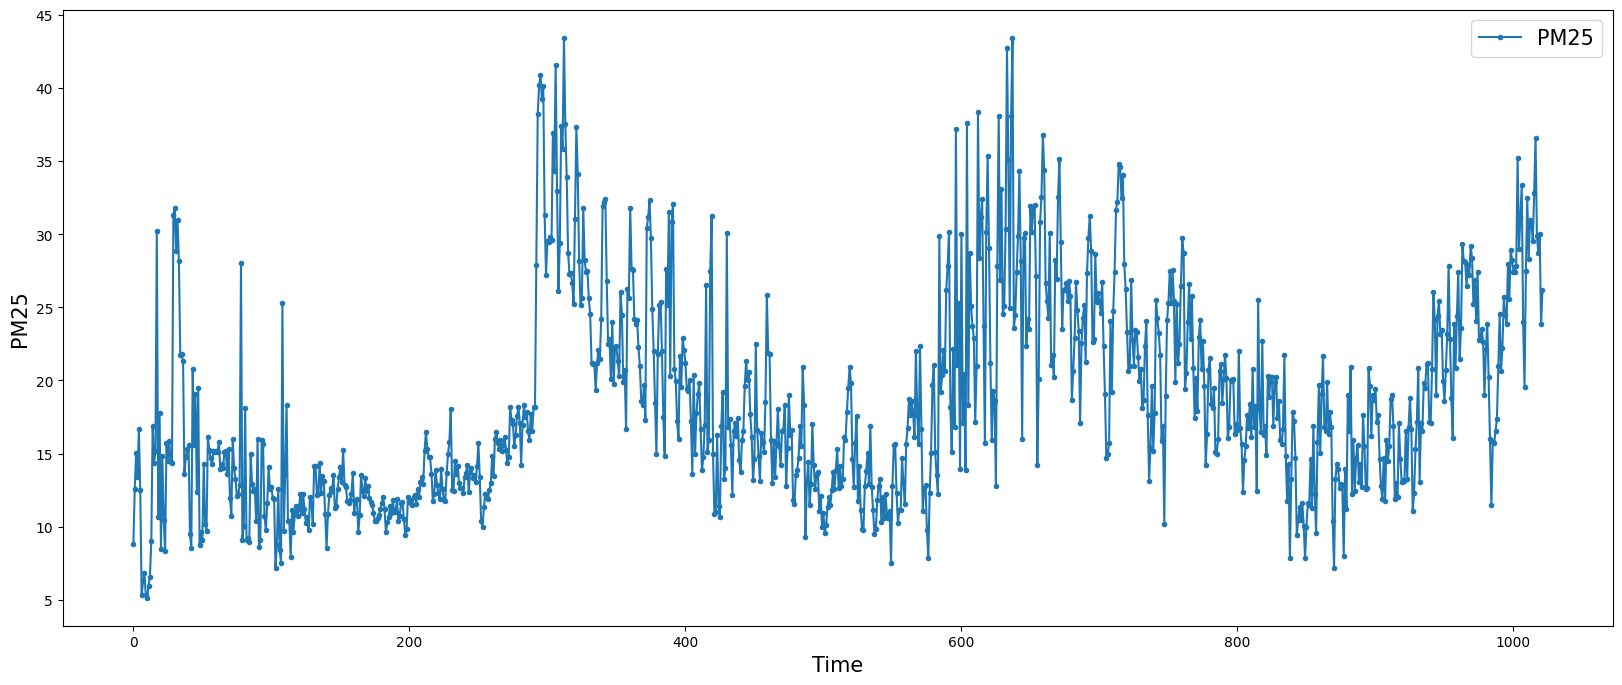

In [23]:
plot_1_data(data=y_test, datalabel="PM25", xlabel="Time", ylabel="PM25", figsize=(20, 8))

### Extract metadata columns

In [24]:
X_inference_ij_columns = df_mpair_inference.loc[:, ["i", "j"]]
X_inference_ij_columns

,i,j
time,,
2021-01-01,0,3
2021-01-02,0,3
2021-01-03,0,3
2021-01-04,0,3
2021-01-05,0,3
...,...,...
2022-12-27,34,27
2022-12-28,34,27
2022-12-29,34,27


### Scale data

In [25]:
mpair_Xtrain_scaler = MinMaxScaler()
X_train_scaled = mpair_Xtrain_scaler.fit_transform(X_train)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,1.000,0.290460,0.299178,0.334582,0.462968,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
1,1.0,1.000,0.258031,0.248661,0.359716,0.398351,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.058140
2,1.0,1.000,0.392658,0.290958,0.310267,0.190687,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
3,1.0,1.000,0.435819,0.318697,0.385016,0.215725,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
4,1.0,1.000,0.430899,0.339159,0.327940,0.347729,0.000000,0.00000,0.0,1.000000,0.749231,0.00000,0.992527,1.0,1.000000,0.304158,0.000000,0.189582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,0.0,0.375,0.425930,0.447946,0.281480,0.257233,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.194161
3266,0.0,0.375,0.422952,0.321101,0.418811,0.624682,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.150867
3267,0.0,0.375,0.409944,0.512338,0.326514,0.276753,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.194161
3268,0.0,0.375,0.494159,0.588618,0.336141,0.324925,0.915791,0.79283,1.0,0.250325,0.000000,0.88279,0.000000,0.0,0.163994,0.249630,0.709483,0.194161


In [26]:
mpair_ytrain_scaler = MinMaxScaler()
y_train_scaled = mpair_ytrain_scaler.fit_transform(y_train)
pd.DataFrame(y_train_scaled, columns=y_train.columns)

,pm25
0,0.200698
1,0.251271
2,0.293140
3,0.304793
4,0.298134
...,...
3265,0.509158
3266,0.249451
3267,0.246389
3268,0.377008


In [27]:
mpair_Xval_scaler = MinMaxScaler()
X_val_scaled = mpair_Xval_scaler.fit_transform(X_val)
pd.DataFrame(X_val_scaled, columns=X_val.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,0.0,0.572139,0.567860,0.384497,0.142883,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
1,1.0,0.0,0.503495,0.244724,0.478411,0.550711,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.081846
2,1.0,0.0,0.362105,0.268160,0.392539,0.756533,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
3,1.0,0.0,0.369632,0.337467,0.301567,0.323125,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
4,1.0,0.0,0.498835,0.526786,0.361229,0.280808,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,0.0,0.0,0.321299,0.481278,0.486433,0.428915,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.174430
814,0.0,0.0,0.356310,0.476959,0.363497,0.373068,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.174430
815,0.0,0.0,0.491640,0.470420,0.408990,0.169505,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.174430
816,0.0,0.0,0.570821,0.360563,0.381331,0.586358,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.162002


In [28]:
mpair_yval_scaler = MinMaxScaler()
y_val_scaled = mpair_yval_scaler.fit_transform(y_val)
pd.DataFrame(y_val_scaled, columns=y_val.columns)

,pm25
0,0.498014
1,0.415821
2,0.290341
3,0.410515
4,0.369334
...,...
813,0.165626
814,0.175289
815,0.171182
816,0.159876


In [29]:
mpair_Xtest_scaler = MinMaxScaler()
X_test_scaled = mpair_Xtest_scaler.fit_transform(X_test)
pd.DataFrame(X_test_scaled, columns=X_test.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,1.0,0.420125,0.653496,0.517543,0.422042,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.248588
1,1.0,1.0,0.350335,0.620364,0.507201,0.419709,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.342893
2,1.0,1.0,0.373492,0.621068,0.522464,0.367865,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.186308
3,1.0,1.0,0.449077,0.565920,0.395077,0.259710,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.186308
4,1.0,1.0,0.436151,0.590671,0.359889,0.374984,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.157566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,0.0,0.0,0.189807,0.400052,0.334777,0.154045,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.273820
1018,0.0,0.0,0.383213,0.230622,0.450426,0.242390,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.232350
1019,0.0,0.0,0.375056,0.247595,0.461675,0.246576,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.037150
1020,0.0,0.0,0.305402,0.179661,0.318825,0.610271,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.273820


In [30]:
mpair_ytest_scaler = MinMaxScaler()
y_test_scaled = mpair_ytest_scaler.fit_transform(y_test)
pd.DataFrame(y_test_scaled, columns=y_test.columns)

,pm25
0,0.095314
1,0.193623
2,0.259048
3,0.216363
4,0.300879
...,...
1017,0.646617
1018,0.615592
1019,0.649759
1020,0.488867


In [31]:
mpair_Xinference_scaler = MinMaxScaler()
X_inference_scaled = mpair_Xinference_scaler.fit_transform(X_inference)
pd.DataFrame(X_inference_scaled, columns=X_inference.columns)

,lat,lon,tmp,rh,hpbl,wspd,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,1.0,0.000000,0.377580,0.308914,0.354281,0.477011,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
1,1.0,0.000000,0.295472,0.420709,0.301440,0.318837,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
2,1.0,0.000000,0.373292,0.391269,0.248758,0.254553,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
3,1.0,0.000000,0.411267,0.460537,0.442676,0.345783,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.109521
4,1.0,0.000000,0.371630,0.522220,0.332955,0.311317,0.002224,0.141639,0.0,0.010802,0.062022,0.030913,0.063024,0.395138,0.703151,0.014570,0.0,0.112335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708095,0.0,0.857143,0.341558,0.563799,0.272944,0.235005,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.088991
708096,0.0,0.857143,0.374293,0.607092,0.248323,0.184759,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.088991
708097,0.0,0.857143,0.403927,0.632859,0.262799,0.159747,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.040508
708098,0.0,0.857143,0.340895,0.566729,0.143866,0.231359,0.020028,0.071699,0.0,0.058329,0.105059,0.049846,0.010148,0.300736,0.093912,0.457187,0.0,0.088991


## LSTM prediction other locations

### Evaluation board

In [32]:
evaluation_board = {'dim_reduction_method': [],
                    'dim_after_reduction': [],
                    'prediction_method':[],
                    'mae (test data)': [],
                    'mse (test data)': [],
                    'r2 (test data)': []}

### Common functions

In [33]:
def reframe_past_future(sequence_X, sequence_y=None, n_past=1, n_future=1):
    ret_X, ret_y = list(), list()
    target_sequence = np.hstack((sequence_X, sequence_y)) if sequence_y is not None else sequence_X
    for window_start in range(len(target_sequence)):
        # find the end of this pattern
        past_end = window_start + n_past
        future_end = past_end + n_future

        # check if we are beyond the dataset
        if future_end > len(target_sequence):
            break
        # Append to result
        ret_X.append(target_sequence[window_start:past_end, :-1] if sequence_y is not None else target_sequence[window_start:past_end, :])
        ret_y.append(target_sequence[past_end:future_end, -1] if sequence_y is not None else target_sequence[past_end:future_end, :])

    return np.array(ret_X), np.array(ret_y)

# Define lstm model
def getLSTMmodel(n_past,n_future, n_features):
    model = Sequential()
    encoder_input = Input(shape=(n_past, n_features))
    encoder_lstm, state_h, state_c = LSTM(100, activation="relu", return_state=True)(encoder_input)
    decoder_input = RepeatVector(n_future)(encoder_lstm)
    decoder_lstm = LSTM(100, activation="relu", return_sequences=True)(decoder_input, initial_state = [state_h, state_c])
    decoder_dense_1 = TimeDistributed(Dense(100, activation="relu"))(decoder_lstm)
    decoder_dense_2 = TimeDistributed(Dense(1))(decoder_dense_1)
    model = Model(encoder_input, decoder_dense_2)
    #model.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.001))
    model.compile(loss=Huber(delta=1.0), optimizer=Adam(learning_rate=1e-3))
    return model

# LSTM Prediction
def predictLSTM(X_train, y_train, X_val, y_val, X_test, y_test, X_inference):
    # Define metadata
    n_past = conf["prediction"]["n_past"]
    n_future = conf["prediction"]["n_future"]
    
    # Reframe train data
    print(f"X_train.shape = {X_train.shape}\ny_train.shape = {y_train.shape}")
    X_train_reframed, y_train_reframed = reframe_past_future(X_train, y_train, n_past, n_future)
    print(f"X_train_reframed.shape = {X_train_reframed.shape}\ny_train_reframed.shape = {y_train_reframed.shape}")
    
    # Reframe validation data
    print(f"X_val.shape = {X_val.shape}\ny_val.shape = {y_val.shape}")
    X_val_reframed, y_val_reframed = reframe_past_future(X_val, y_val, n_past, n_future)
    print(f"X_val_reframed.shape = {X_val_reframed.shape}\ny_val_reframed.shape = {y_val_reframed.shape}")
    
    # Pad and reframe test data
    print(f"X_test.shape = {X_test.shape}\ny_test.shape = {y_test.shape}")
    X_test_padded = np.vstack((np.tile(X_test[0], (n_past, 1)), X_test))
    y_test_padded = np.vstack((np.tile(y_test[0], (n_past, 1)), y_test))
    print(f"X_test_padded.shape = {X_test_padded.shape}\ny_test_padded.shape = {y_test_padded.shape}")
    X_test_reframed, y_test_reframed = reframe_past_future(X_test_padded, y_test_padded, n_past, n_future)
    print(f"X_test_reframed.shape = {X_test_reframed.shape}\ny_test_reframed.shape = {y_test_reframed.shape}")

    # Pad and reframe inference data
    print(f"X_inference.shape = {X_inference.shape}")
    X_inference_padded = np.vstack((np.tile(X_inference[0], (n_past, 1)), X_inference))
    print(f"X_inference_padded.shape = {X_inference_padded.shape}")
    X_inference_reframed, _ = reframe_past_future(X_inference_padded, n_past=n_past, n_future=n_future)
    print(f"X_inference_refamed.shape = {X_inference_reframed.shape}")
    
    # Define callbacks
    checkpoint = ModelCheckpoint(filepath=f'{conf["workspace"]["model_checkpoints_dir"]}/lstm_prediction_mpair.keras', save_best_only=True)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        min_delta=0.001
    )
    
    # Fit model
    n_features = X_train_reframed.shape[-1]
    model = getLSTMmodel(n_past, n_future, n_features)
    model.fit(X_train_reframed, y_train_reframed,
            epochs=conf["prediction"]["epochs"],
            batch_size=conf["prediction"]["batch_size"],
            verbose=1,
            validation_data=(X_val_reframed, y_val_reframed),
            #callbacks=[checkpoint, early_stopping],
            callbacks=[checkpoint],
            shuffle=False)
    
    # Evaluation
    y_predicted = model.predict(X_test_reframed, verbose=1)
    inverted_y_predicted = mpair_ytest_scaler.inverse_transform(y_predicted[:, 0, :]) # Only applicable when n_future = 1
    inverted_y_predicted = inverted_y_predicted.reshape(-1, 1)
    inverted_y_test = mpair_ytest_scaler.inverse_transform(y_test)
    print(f"inverted_y_predicted.shape = {inverted_y_predicted.shape}")
    mae = mean_absolute_error(inverted_y_test, inverted_y_predicted)
    mse = mean_squared_error(inverted_y_test, inverted_y_predicted)
    r2 = r2_score(inverted_y_test, inverted_y_predicted)
    print(f"mae = {mae}")
    print(f"mse = {mse}")
    print(f"r2 = {r2}")
    plot_2_data(data1=inverted_y_predicted,
            data2=inverted_y_test,
            datalabel1="Predicted values",
            datalabel2="Actual values",
            xlabel="Time step",
            ylabel="PM2.5")

    # Inference
    y_inference = model.predict(X_inference_reframed, verbose=1)
    inverted_y_inference = mpair_ytest_scaler.inverse_transform(y_inference[:, 0, :]) # Only applicable when n_future = 1
    df_inference = pd.DataFrame(inverted_y_inference, index=X_inference_ij_columns.index, columns=["pm25"])
    df_inference = pd.concat([df_inference, X_inference_ij_columns], axis=1)
    print(f"df_inference.shape = {df_inference.shape}")
    return df_inference, mae, mse, r2

### Prediction no encoder

#### LSTM prediction

X_train.shape = (3270, 18)
y_train.shape = (3270, 1)
X_train_reframed.shape = (3263, 7, 18)
y_train_reframed.shape = (3263, 1)
X_val.shape = (818, 18)
y_val.shape = (818, 1)
X_val_reframed.shape = (811, 7, 18)
y_val_reframed.shape = (811, 1)
X_test.shape = (1022, 18)
y_test.shape = (1022, 1)
X_test_padded.shape = (1029, 18)
y_test_padded.shape = (1029, 1)
X_test_reframed.shape = (1022, 7, 18)
y_test_reframed.shape = (1022, 1)
X_inference.shape = (708100, 18)
X_inference_padded.shape = (708107, 18)
X_inference_refamed.shape = (708100, 7, 18)
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0081 - val_loss: 0.0301
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075 - val_loss: 0.0408
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0063 - val_loss: 0.0485
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0063 - val_loss: 0.0253
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0066 - val_loss: 0.0162
Epoch 6/200
26/26 ━━━━━

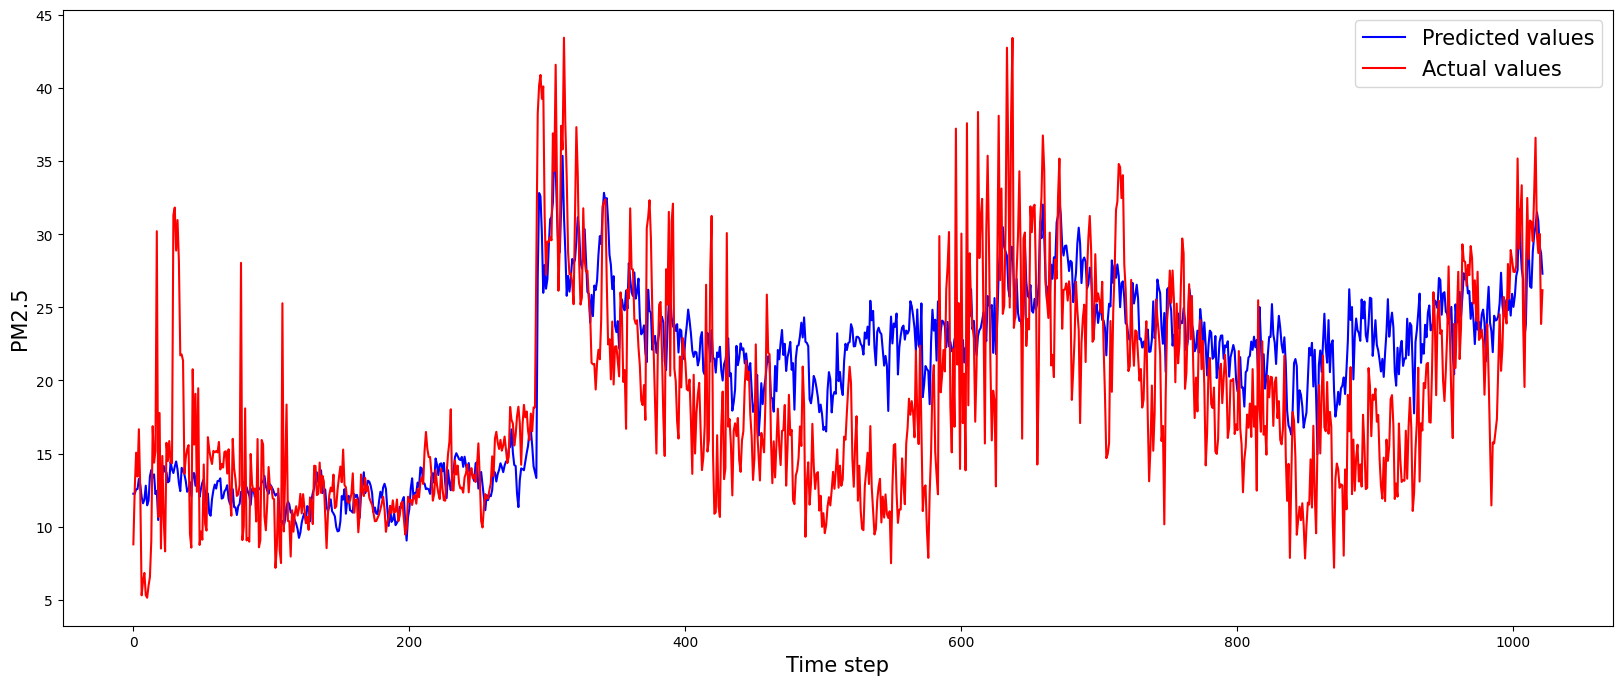

22129/22129 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step
df_inference.shape = (708100, 3)


In [34]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled,
            y_train=y_train_scaled,
            X_val=X_val_scaled,
            y_val=y_val_scaled,
            X_test=X_test_scaled,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled)

evaluation_board['dim_reduction_method'].append("None")
evaluation_board['dim_after_reduction'].append("None")
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [35]:
df_mpair_inference

,pm25,i,j
time,,,
2021-01-01,10.453900,0,3
2021-01-02,10.453900,0,3
2021-01-03,10.986771,0,3
2021-01-04,11.392818,0,3
2021-01-05,10.620507,0,3
...,...,...,...
2022-12-27,12.161595,34,27
2022-12-28,11.941158,34,27
2022-12-29,11.970166,34,27


In [36]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

[(12, 22), (15, 14), (15, 18), (16, 16), (16, 17), (17, 17), (18, 14)]

In [37]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

,i,j,station,pm25
time,,,,
2021-01-01,15,14,213.0,32.480901
2021-01-02,15,14,213.0,44.931935
2021-01-03,15,14,213.0,52.310826
2021-01-04,15,14,213.0,50.794432
2021-01-05,15,14,213.0,52.556760
...,...,...,...,...
2022-12-27,15,14,213.0,37.843260
2022-12-28,15,14,213.0,33.439382
2022-12-29,15,14,213.0,31.853402


In [38]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

,pm25,i,j
time,,,
2021-01-01,12.959264,15,16
2021-01-02,12.965404,15,16
2021-01-03,13.316802,15,16
2021-01-04,13.519316,15,16
2021-01-05,13.241857,15,16
...,...,...,...
2022-12-27,13.492154,15,16
2022-12-28,13.327394,15,16
2022-12-29,13.114003,15,16


In [39]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

,pm25,i,j
time,,,
2021-01-01,11.710197,34,27
2021-01-02,11.532270,34,27
2021-01-03,11.592618,34,27
2021-01-04,11.201546,34,27
2021-01-05,11.588224,34,27
...,...,...,...
2022-12-27,12.161595,34,27
2022-12-28,11.941158,34,27
2022-12-29,11.970166,34,27


In [40]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)
mae between location_with_station and random_location = 15.854939848837663
mae between location_with_station and nearest_location = 13.758632346898967


### Prediction with lstms2s encoder

#### Encode data

In [41]:
lstms2s_encoder = list(filter(lambda model: ("aod_lstms2s" in model) & ("no_pm25_3km" in model) , glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(lstms2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(lstms2s_encoder)
print(encoder_model.summary())

# Encode train data
print(f"X_train_scaled.shape = {X_train_scaled.shape}")
X_train_scaled_padded = np.vstack((np.tile(X_train_scaled[0], (n_past, 1)),
                                    X_train_scaled,
                                    np.tile(X_train_scaled[-1], (n_future-1, 1))))
print(f"X_train_scaled_padded.shape = {X_train_scaled_padded.shape}")
X_train_scaled_reframed, _ = reframe_past_future(X_train_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_train_scaled_reframed.shape = {X_train_scaled_reframed.shape}")
X_train_scaled_lstms2s_encoded = encoder_model.predict(X_train_scaled_reframed)
print(f"X_train_scaled_lstms2s_encoded.shape = {X_train_scaled_lstms2s_encoded.shape}")
print("=" * 100)

# Encode validation data
print(f"X_val_scaled.shape = {X_val_scaled.shape}")
X_val_scaled_padded = np.vstack((np.tile(X_val_scaled[0], (n_past, 1)),
                                 X_val_scaled,
                                np.tile(X_val_scaled[-1], (n_future-1, 1))))
print(f"X_val_scaled_padded.shape = {X_val_scaled_padded.shape}")
X_val_scaled_reframed, _ = reframe_past_future(X_val_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_val_scaled_reframed.shape = {X_val_scaled_reframed.shape}")
X_val_scaled_lstms2s_encoded = encoder_model.predict(X_val_scaled_reframed)
print(f"X_val_scaled_lstms2s_encoded.shape = {X_val_scaled_lstms2s_encoded.shape}")
print("=" * 100)

# Encode test data
print(f"X_test_scaled.shape = {X_test_scaled.shape}")
X_test_scaled_padded = np.vstack((np.tile(X_test_scaled[0], (n_past, 1)),
                                 X_test_scaled,
                                np.tile(X_test_scaled[-1], (n_future-1, 1))))
print(f"X_test_scaled_padded.shape = {X_test_scaled_padded.shape}")
X_test_scaled_reframed, _ = reframe_past_future(X_test_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_test_scaled_reframed.shape = {X_test_scaled_reframed.shape}")
X_test_scaled_lstms2s_encoded = encoder_model.predict(X_test_scaled_reframed)
print(f"X_test_scaled_lstms2s_encoded.shape = {X_test_scaled_lstms2s_encoded.shape}")
print("=" * 100)

# Encode inference data
print(f"X_inference_scaled.shape = {X_inference_scaled.shape}")
X_inference_scaled_padded = np.vstack((np.tile(X_inference_scaled[0], (n_past, 1)),
                                 X_inference_scaled,
                                np.tile(X_inference_scaled[-1], (n_future-1, 1))))
print(f"X_inference_scaled_padded.shape = {X_inference_scaled_padded.shape}")
X_inference_scaled_reframed, _ = reframe_past_future(X_inference_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_inference_scaled_reframed.shape = {X_inference_scaled_reframed.shape}")
X_inference_scaled_lstms2s_encoded = encoder_model.predict(X_inference_scaled_reframed)
print(f"X_inference_scaled_lstms2s_encoded.shape = {X_inference_scaled_lstms2s_encoded.shape}")

/le_thanh_van_118/workspace/hiep_workspace/best_reduction_models/aod_lstms2s_dim_reduction_15_features_no_pm25_3km_encoder.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "aod_lstms2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,697 (920.70 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,132 (613.80 KB)

None
X_train_scaled.shape = (3270, 18)
X_train_scaled_padded.shape = (3283, 18)
X_train_scaled_reframed.shape = (3270, 7, 18)


I0000 00:00:1754386536.435328 1644422 service.cc:152] XLA service 0x7ce934005ac0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754386536.435381 1644422 service.cc:160]   StreamExecutor device (0): Host, Default Version


 49/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

I0000 00:00:1754386536.715203 1644422 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
X_train_scaled_lstms2s_encoded.shape = (3270, 15)
X_val_scaled.shape = (818, 18)
X_val_scaled_padded.shape = (831, 18)
X_val_scaled_reframed.shape = (818, 7, 18)
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
X_val_scaled_lstms2s_encoded.shape = (818, 15)
X_test_scaled.shape = (1022, 18)
X_test_scaled_padded.shape = (1035, 18)
X_test_scaled_reframed.shape = (1022, 7, 18)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
X_test_scaled_lstms2s_encoded.shape = (1022, 15)
X_inference_scaled.shape = (708100, 18)
X_inference_scaled_padded.shape = (708113, 18)
X_inference_scaled_reframed.shape = (708100, 7, 18)
22129/22129 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step
X_inference_scaled_lstms2s_encoded.shape = (708100, 15)


#### LSTM prediction

X_train.shape = (3270, 15)
y_train.shape = (3270, 1)
X_train_reframed.shape = (3263, 7, 15)
y_train_reframed.shape = (3263, 1)
X_val.shape = (818, 15)
y_val.shape = (818, 1)
X_val_reframed.shape = (811, 7, 15)
y_val_reframed.shape = (811, 1)
X_test.shape = (1022, 15)
y_test.shape = (1022, 1)
X_test_padded.shape = (1029, 15)
y_test_padded.shape = (1029, 1)
X_test_reframed.shape = (1022, 7, 15)
y_test_reframed.shape = (1022, 1)
X_inference.shape = (708100, 15)
X_inference_padded.shape = (708107, 15)
X_inference_refamed.shape = (708100, 7, 15)
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0108 - val_loss: 0.0173
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0210 - val_loss: 0.0143
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058 - val_loss: 0.0131
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0058 - val_loss: 0.0136
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - val_loss: 0.0131
Epoch 6/200
26/26 ━━━━━

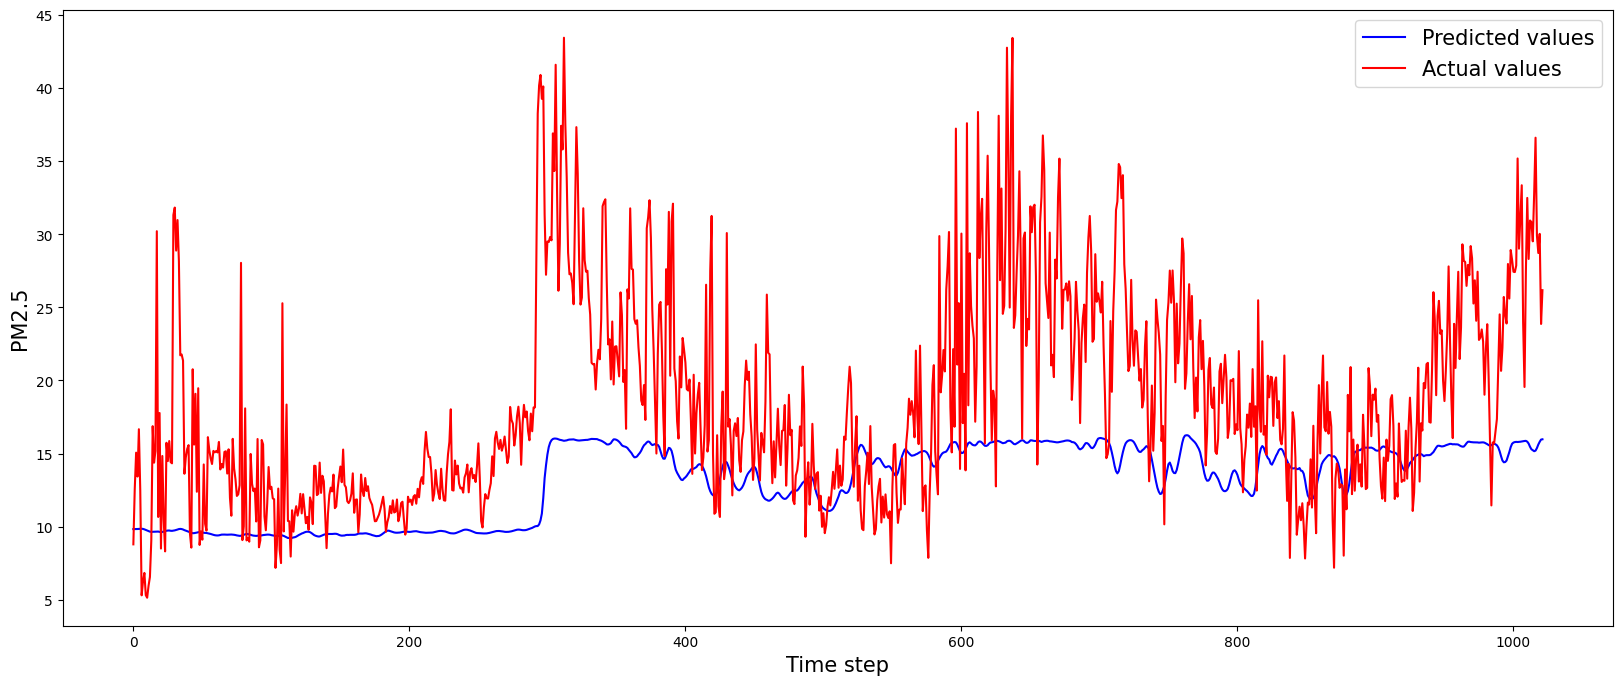

11496/22129 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step

In [ ]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled_lstms2s_encoded,
            y_train=y_train_scaled,
            X_val=X_val_scaled_lstms2s_encoded,
            y_val=y_val_scaled,
            X_test=X_test_scaled_lstms2s_encoded,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled_lstms2s_encoded)

evaluation_board['dim_reduction_method'].append("LSTM-Seq2Seq")
evaluation_board['dim_after_reduction'].append(X_train_scaled_lstms2s_encoded.shape[-1])
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [ ]:
df_mpair_inference

In [ ]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

In [ ]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

In [ ]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

In [ ]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

In [ ]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

### Prediction with grus2s encoder

#### Encode data

In [ ]:
grus2s_encoder = list(filter(lambda model: ("aod_grus2s" in model) & ("no_pm25_3km" in model) , glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(grus2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(grus2s_encoder)
print(encoder_model.summary())

# Encode train data
print(f"X_train_scaled.shape = {X_train_scaled.shape}")
X_train_scaled_padded = np.vstack((np.tile(X_train_scaled[0], (n_past, 1)),
                                    X_train_scaled,
                                    np.tile(X_train_scaled[-1], (n_future-1, 1))))
print(f"X_train_scaled_padded.shape = {X_train_scaled_padded.shape}")
X_train_scaled_reframed, _ = reframe_past_future(X_train_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_train_scaled_reframed.shape = {X_train_scaled_reframed.shape}")
X_train_scaled_grus2s_encoded = encoder_model.predict(X_train_scaled_reframed)
print(f"X_train_scaled_grus2s_encoded.shape = {X_train_scaled_grus2s_encoded.shape}")
print("=" * 100)

# Encode validation data
print(f"X_val_scaled.shape = {X_val_scaled.shape}")
X_val_scaled_padded = np.vstack((np.tile(X_val_scaled[0], (n_past, 1)),
                                 X_val_scaled,
                                np.tile(X_val_scaled[-1], (n_future-1, 1))))
print(f"X_val_scaled_padded.shape = {X_val_scaled_padded.shape}")
X_val_scaled_reframed, _ = reframe_past_future(X_val_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_val_scaled_reframed.shape = {X_val_scaled_reframed.shape}")
X_val_scaled_grus2s_encoded = encoder_model.predict(X_val_scaled_reframed)
print(f"X_val_scaled_grus2s_encoded.shape = {X_val_scaled_grus2s_encoded.shape}")
print("=" * 100)

# Encode test data
print(f"X_test_scaled.shape = {X_test_scaled.shape}")
X_test_scaled_padded = np.vstack((np.tile(X_test_scaled[0], (n_past, 1)),
                                 X_test_scaled,
                                np.tile(X_test_scaled[-1], (n_future-1, 1))))
print(f"X_test_scaled_padded.shape = {X_test_scaled_padded.shape}")
X_test_scaled_reframed, _ = reframe_past_future(X_test_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_test_scaled_reframed.shape = {X_test_scaled_reframed.shape}")
X_test_scaled_grus2s_encoded = encoder_model.predict(X_test_scaled_reframed)
print(f"X_test_scaled_grus2s_encoded.shape = {X_test_scaled_grus2s_encoded.shape}")
print("=" * 100)

# Encode inference data
print(f"X_inference_scaled.shape = {X_inference_scaled.shape}")
X_inference_scaled_padded = np.vstack((np.tile(X_inference_scaled[0], (n_past, 1)),
                                 X_inference_scaled,
                                np.tile(X_inference_scaled[-1], (n_future-1, 1))))
print(f"X_inference_scaled_padded.shape = {X_inference_scaled_padded.shape}")
X_inference_scaled_reframed, _ = reframe_past_future(X_inference_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_inference_scaled_reframed.shape = {X_inference_scaled_reframed.shape}")
X_inference_scaled_grus2s_encoded = encoder_model.predict(X_inference_scaled_reframed)
print(f"X_inference_scaled_grus2s_encoded.shape = {X_inference_scaled_grus2s_encoded.shape}")

#### LSTM prediction

In [ ]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled_grus2s_encoded,
            y_train=y_train_scaled,
            X_val=X_val_scaled_grus2s_encoded,
            y_val=y_val_scaled,
            X_test=X_test_scaled_grus2s_encoded,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled_grus2s_encoded)

evaluation_board['dim_reduction_method'].append("GRU-Seq2Seq")
evaluation_board['dim_after_reduction'].append(X_train_scaled_grus2s_encoded.shape[-1])
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [ ]:
df_mpair_inference

In [ ]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

In [ ]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

In [ ]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

In [ ]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

In [ ]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

### Prediction with cnnlstms2s encoder

#### Encode data

In [ ]:
cnnlstms2s_encoder = list(filter(lambda model: ("aod_cnnlstms2s" in model) & ("no_pm25_3km" in model) , glob.glob(f'{conf["workspace"]["best_reduction_models_dir"]}/*')))[0]
print(cnnlstms2s_encoder)

n_past = conf["reduction"]["n_past"]
n_future = conf["reduction"]["n_future"]

encoder_model = load_model(cnnlstms2s_encoder)
print(encoder_model.summary())

# Encode train data
print(f"X_train_scaled.shape = {X_train_scaled.shape}")
X_train_scaled_padded = np.vstack((np.tile(X_train_scaled[0], (n_past, 1)),
                                    X_train_scaled,
                                    np.tile(X_train_scaled[-1], (n_future-1, 1))))
print(f"X_train_scaled_padded.shape = {X_train_scaled_padded.shape}")
X_train_scaled_reframed, _ = reframe_past_future(X_train_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_train_scaled_reframed.shape = {X_train_scaled_reframed.shape}")
X_train_scaled_cnnlstms2s_encoded = encoder_model.predict(X_train_scaled_reframed)
print(f"X_train_scaled_cnnlstms2s_encoded.shape = {X_train_scaled_cnnlstms2s_encoded.shape}")
print("=" * 100)

# Encode validation data
print(f"X_val_scaled.shape = {X_val_scaled.shape}")
X_val_scaled_padded = np.vstack((np.tile(X_val_scaled[0], (n_past, 1)),
                                 X_val_scaled,
                                np.tile(X_val_scaled[-1], (n_future-1, 1))))
print(f"X_val_scaled_padded.shape = {X_val_scaled_padded.shape}")
X_val_scaled_reframed, _ = reframe_past_future(X_val_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_val_scaled_reframed.shape = {X_val_scaled_reframed.shape}")
X_val_scaled_cnnlstms2s_encoded = encoder_model.predict(X_val_scaled_reframed)
print(f"X_val_scaled_cnnlstms2s_encoded.shape = {X_val_scaled_cnnlstms2s_encoded.shape}")
print("=" * 100)

# Encode test data
print(f"X_test_scaled.shape = {X_test_scaled.shape}")
X_test_scaled_padded = np.vstack((np.tile(X_test_scaled[0], (n_past, 1)),
                                 X_test_scaled,
                                np.tile(X_test_scaled[-1], (n_future-1, 1))))
print(f"X_test_scaled_padded.shape = {X_test_scaled_padded.shape}")
X_test_scaled_reframed, _ = reframe_past_future(X_test_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_test_scaled_reframed.shape = {X_test_scaled_reframed.shape}")
X_test_scaled_cnnlstms2s_encoded = encoder_model.predict(X_test_scaled_reframed)
print(f"X_test_scaled_cnnlstms2s_encoded.shape = {X_test_scaled_cnnlstms2s_encoded.shape}")
print("=" * 100)

# Encode inference data
print(f"X_inference_scaled.shape = {X_inference_scaled.shape}")
X_inference_scaled_padded = np.vstack((np.tile(X_inference_scaled[0], (n_past, 1)),
                                 X_inference_scaled,
                                np.tile(X_inference_scaled[-1], (n_future-1, 1))))
print(f"X_inference_scaled_padded.shape = {X_inference_scaled_padded.shape}")
X_inference_scaled_reframed, _ = reframe_past_future(X_inference_scaled_padded, n_past=n_past, n_future=n_future)
print(f"X_inference_scaled_reframed.shape = {X_inference_scaled_reframed.shape}")
X_inference_scaled_cnnlstms2s_encoded = encoder_model.predict(X_inference_scaled_reframed)
print(f"X_inference_scaled_cnnlstms2s_encoded.shape = {X_inference_scaled_cnnlstms2s_encoded.shape}")

#### LSTM prediction

In [ ]:
df_mpair_inference, mae, mse, r2 = predictLSTM(X_train=X_train_scaled_cnnlstms2s_encoded,
            y_train=y_train_scaled,
            X_val=X_val_scaled_cnnlstms2s_encoded,
            y_val=y_val_scaled,
            X_test=X_test_scaled_cnnlstms2s_encoded,
            y_test=y_test_scaled,
            X_inference=X_inference_scaled_cnnlstms2s_encoded)

evaluation_board['dim_reduction_method'].append("CNN-LSTM-Seq2Seq")
evaluation_board['dim_after_reduction'].append(X_train_scaled_cnnlstms2s_encoded.shape[-1])
evaluation_board['prediction_method'].append("LSTM")
evaluation_board['mae (test data)'].append(mae)
evaluation_board['mse (test data)'].append(mse)
evaluation_board['r2 (test data)'].append(r2)

#### Compare with other locations

In [ ]:
df_mpair_inference

In [ ]:
list(df_mpair_train_val_test[["i", "j"]].drop_duplicates().itertuples(name=None, index=None))

In [ ]:
location_with_station = (15, 14)
nearest_location = (15, 16)
random_location = (34, 27)

df_location_with_station = df_mpair_train_val_test.loc[(df_mpair_train_val_test["i"] == location_with_station[0]) & 
                                                       (df_mpair_train_val_test["j"] == location_with_station[1]),
                                                        ["i", "j", "station", "pm25"]]
df_location_with_station

In [ ]:
df_nearest_location = df_mpair_inference.loc[(df_mpair_inference["i"] == nearest_location[0]) & (df_mpair_inference["j"] == nearest_location[1])]
df_nearest_location

In [ ]:
df_random_location = df_mpair_inference.loc[(df_mpair_inference["i"] == random_location[0]) & (df_mpair_inference["j"] == random_location[1])]
df_random_location

In [ ]:
print(f"location_with_station = {location_with_station}")
print(f"nearest_location = {nearest_location}")
print(f"random_location = {random_location}")
print(f"mae between location_with_station and random_location = {mean_absolute_error(df_location_with_station['pm25'], df_random_location['pm25'])}")
print(f"mae between location_with_station and nearest_location = {mean_absolute_error(df_location_with_station['pm25'], df_nearest_location['pm25'])}")

## Result

In [ ]:
pd.DataFrame(evaluation_board)